In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sample-sales-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F435%2F896%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075612Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1780cf91ddfa28a3aa05cf33a5dc1adb1d293ac9a427cb208005b67459fa2aed37cd67f5782ebccb52fd7b70617653038776e618f84baa0ed24dfbcf5e89f21081721a579ff1688140cea6ad743de82c3a828669de6e4ea0212b3b4b249ad790356919ae992f2a02ac8e378fb8d33b9bc109c0d9ff8ad8239b68a0fabd237db56ad9a8dfc3591f91d9190db78edf6b4a93594c92f672d0b9359c50e99c5bbe47d27cd40051cbddb7bb46b96363e60b66ac27f499e1eaba2be1569af1be8e9c9121e5abc24feac6b98b7cc671572cfb3fae884efda6bd3f1c42544895155dc91d7063b628e25f5a992207d2e6687d5ec272f8dba72f5667fd402c1601fa63c0cd,hourly-energy-consumption:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F48149%2F87794%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4a327858ddb8c9448cff9448ac4cf7def6fdb748e198b90268aeb13000550090b5738309869d78228cb973a1da5a1410e3112b4b8ccca1b368be00399d73b136b9cc0d8736497f415f7b52b6dadf48ba5e6ad2e53f58a337edea61cd84c5b7bbc83bb033234c3746f755f270d1e87b1bd3a84807ea76905e3ff004b68b5e1938050272cd03b16b979c879416dfe0ff45e47e8b1459cd57ef3b4660852790ee0bfa68b23d22ff803c380fe490853b2561d8400bd737941b32c16b8e49ce939db54a8547e0deed61221e02a1d4afa0ecf5fa36a640928ad226f1e169be51eab6d968c0aae8a773605f860f5c85038903607eb1991f8f91e1a221d198d355d70ad1,melbourne-housing-market:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F423%2F126865%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1d9c20fb8f0871771fd8d3147752c8924c133114fae6fa4bdd8e80d130a7c9193f24cf099558bcc2951423e9d1033860ddb21a98f4b5519165cccee0d8aadf1e3829ac7bb24ce304b9ad63d4c8a0c80eeb83c23c1be310147c867d66b926be9b07b8954e04b28280a6087378c071a98224b0d0fc6cf723fc2e637440a04bd3822fd505840899002ae3b8b7e7d973d404f325061dda5e4167dcda43ae139903b51b7d3cdc3bf93fc2afe81107d31d88d4e902c17b8f9d2f7a590a6293a154d22f8d44876ed7228db9a5975380eb0e5885b451da9ec8ded6c0eb4cde737cfac62d4c909602fdc6a566099035f46ebe20ac614f978d88947e9ca48621e0fd2ea02b,youtube-social-network:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F328953%2F658141%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4ab247689484911f001bdbfc10e3e178945b1bcf095315e33e739e7cd145810f3ed8d40a5eeacce01cd64fcb606d728cff47d2c17c001d1b7e54b30e99ae511a8513ff137f94f8378c50dc9c26048fb155c8db8b1301246ca814264778c879e4715947728ad68fd3b4d21ab081c73853f58f74308227ca69ca523cadb0492ad9f4e805f5bd3426880efcb614f87fd8c1e9ae7ee17ca766ac97def719b9833cfc8fa00de5f7b11c74e2eb5812d75a1fd2742fb03e44f87d4c275940aa0fc5b02d9487e58d5d6e5dd4787bc8c607632f5f3a8e38fa6f5ea680c9bdb7960b386f062d7682f582e0a50a83f0a8657bd9811bdac56c8631e1cc9cd5eebe2c0ace63b8,airline-passenger-satisfaction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F522275%2F959195%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9496dd1bbd87ae9e4e48c5912488da3ce740d5a3503b320f150fece11ce8aa53cee31fbddb19c730b19138aa1e55bbad987003e09f739efe827ff6713a1068b5f5ab6d257ec9bc2599ff932d731f0cdafbb4cf466a91e105f39f00239b6d6e288377f595edaafc4a6ab0765b537d0bbbc811a34514d7c50005538d28391a1c1cce81bb43bb80a571285037627c4e42fc67ba4cce8c5d895d7809447ccb8d2df180c2b45b1a24268c2c72d88d672eaba7e5ea20e2064262cd5830eded00ff31daa549ffba8e895e306f3afe835224b868f80dd1f0f7c29ef42e01ae0b72459a66a040723e468dd073286deb7777326ff5ac6c71ca641bd1331c024db575463850,violent-crime-rates-by-us-state:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F645058%2F1143498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D16cf0620189fe59043f463ea731b0ac165622e1d96cbca0bce8f2a606899021dc3a477810a380a8c3a5c5daa42dfa8ff0b1e05a2bf60e21376a574cfba259bce0ea3b485289471e705c2d6cd62b3a1d0519538b4f27157947babe5cb1f1a882f35f5e1db301d23f662e1e3c945095dafdafb167627c7b7cdcedca79f18ffd1ce3de46d51210b70d6df7749c85113b7e4d75bfa42be8d30827074eb8755c755252af58d7084b3103d0e919f1faed98cba49ee45cf1c56be92cde5a45d20bd25718ccfb27764c98571e3ad648e7581c5682c8dd1f9b22a17bee1d700453c4e25736c2ba1248fc4197690ff560018b84d7614107a46d20d4d65038c1d12aca83c07,starbucks-customer-retention-malaysia-survey:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F636300%2F1161564%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9d5be484bdd2d9143b376bcf4495e717c6342254c063f825923e8a196b39d780d24bba29ac3a1b148525b056c09a8645d9a6e84b65ac9c281ed969984c088f27f4401c7d3fc4345543efe0be35d68101f437d82c5d05b0030b41876d998d9720666311d471bcf4f11bdd919a88e788d067e677e30a61022ae9dc587e1b62cdbcd5a996a27dfcb66fad2f2408413652dc8abb16a53d0da15c9a8239623086dc650bd1d3207b0064ef922dfb8f9ddefbd7351bbad58b95fb4e92a719f401f6eea57573c50c298393eb4dde2f173c84cf05cc0e99d7108995dfd337daff69015e8209a093cf2f929cc6c891a75ba55d71670ede737cc5724248eb7c6e27afbd42e3,covid19-in-italy:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F545466%2F1719966%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D07088d6d25c237cdda66e1e7c00782fe0df9c27931a1965eb4fa465a21208e79bf3d59d0d7c7420be3193d929ee26f89e89a5aaebbb851daf29388affb3c9b56c7642e9a71f9100fe2322894804c5daf9392dc809e0e5f6726f2c25163770e4c333dcdc91fd058d05b1631839dae50bf10c6bb2d0f7a7750ea9167753dbe9ad1d2735d5a94be121326e2cdb2e81f42af2fe791baa2059930be14c6da66bc66671dfa59178eee1ac260338e928bb6b6f7a4b5137767bf24e2b55d28c91daf250d1cdfe6d216c97dd27639fa3509891292aa5267fcd682c888bba6ca734f49ce8fd295ac969a1a500d5162bf7ed88975bdeb44b1cc09942176dd969b5ee52bcdfa,company-bankruptcy-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1111894%2F1938459%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2b603bef8761b541321ca4c9ddba4badc662b24ad0a35f60189b78cf396e886f8976f749426f618243a7165e991ff345cf20c7e4bd91381ef8f7a9e8c2449db3a9fc2c572ce0cc5bfeecd667e8da59b048dddc175b7629c9772984b6382a8aacf174f19e61349f0f8feb237ec1755d39d2258d61ed7956f218793b1cf416597a5e815e41437b536a0f5b12ae96933b1e4dcb2c3b6592869db70f2d55948a4018cecd33d78364349d64522b79f0fe16c1289c0d69ec4e87b94e4ae454de2e133788caf86cf14b7f04f349873cfb3294b16338f5bf772736e02b1cef3b868f4fe4d4d72529214286c6cd9d92b76ed54a9ba63901c65e3dad68b1ef2363aa0194ac,clickstream-data-for-online-shopping:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1269184%2F2115404%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9fcc71234a2683f11fad1fa11d770494bc126d3d7f0de44cb9935818861243fead4eb50b3f299396157f85ac57671bc0526d93506b6384a23e932f73663a8b8b1fd3d9d2925cc544cebb23a400a921451f639cad8524195be8170f6b662c572a5a86eb1bf22a6dd879fb63622c40e0d182405811ee47864930fc6d8f7a3ae25e1ee2bd61595c39a040918e920c42740d23c43b35124161904b17962245697cba50a3d020152a998b0032d59d616685d441cd48b7854994efbce4c3ab7610c1a42b0d35e6feb7705b646e657399365c2ba8ba9247cb2708d8b1272cfcf8f3c0480e685c88e6b7f6c94275ac7768fcc7dfb15522a6250eeb984042caa1456943c4,lacity.org-website-traffic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44159%2F2429390%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D11b9ccf179572a9d691182d97994825d07d46ee596829dd52a54eab2b6ae29ce12ee307d418f913e7f88a005540ebd6b8a4b7f32284b9cd701c39e792e6319dc7237fbd0e97a7a1dd338aa240cf29c562204e5892217347d070b7ffa6e8370e07e6e92298e367c3d712269c812581fddbefaab191c3ee18548a01309e7894d00900f079495db700d39b1b3c6244d1e96f0cbccf3e3d026c06fc194c22f7b86cb783a20ce9b97b82f1e4a1221e7de4f4faba3617a41ffd97869dcae06cca05d494f7d70cb693253607ad6be33e6c873323aabe869bd4e041b605b0270472590af7f8775b5f5e754331d790cf47ee59c2bbe85033ea4a4865b1dc447d6cd39787c,cuisine-rating:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1972526%2F3507850%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3046735e738de0fb6ef1a8f0c477cdc78f3c9168185b35d74ecd5f6c3d173079b90f4c2c8cd80a6c98e04206bf9bf88c36e95b86c86e5dbd61fca8ee60ed69eaeb4ed3dd5b89a2b34f18bd4bcb942c6243aaaee3091fda3c90741381bf61208afb007c8e589891d1c6ade447a1ed136706b317b1aa7cc3cf119b7619a513944d032e9ea50e43af7535cf553e0178ac440ab577217e21bd1e0865463592c5f763a12ffd7901bd49ab6ac4bd4fee3b82b2dd6b623bc1a7748f13d388c497160d73492781d74204eddb2aa8bb0a1c27ac4979a37d28a6a3bec520842ef881e97b153b21119b0b1d9e5c986b5ad94c18227babe1fa123e763df3ad638c729797a4bd,student-performance-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2213802%2F3700232%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D44dc335b8f7376266abeeb89b74fa7a3d9cf1334c625cd209f45860cd27d41b1e3d90f5a645cf8ae980de684620528a89c048ccda289fd9823357169feb5187bb94b45cb9e1de520c5db99c55ad738dac656c1137a5e6d7f53cdd06383356cdbcf524c5b6406ec09d742b50c0f70b2a419c1828695be59fcd7f8c467834f45da5d1a2aa67164a8b518031b7d07b0a847710cb40834d64993786e406fe952d116692a89cbfca141647b71216819f144fffcd4d4d6586be29f8b30e6f9ec56b0606fc52acba32508d1adf488da9e0c398defbb9121cdbcd05a45c30ce7bee9fedac1eb18021f2729b949f157cd05713dfcfc643d6b037f0afeabd9eda2aa8afc61,usa-budget-authority-by-agency-19762022:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2328255%2F3920766%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075614Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D50865dd9efc852a89699340c9a3060e2a648290599fb6e6848f2ed90fbf94d3c5a388e15ac282e6bc61f4b7638b88f36e25fc8cb48e0798d801c7cca1e091389d58765627e7ece7c29779e5450900b85afcc1c4a331de6ac5e5bbeb52fbaff73b7075637ac65613bec1b1ccda60e98f98e26e4daad80e03511008d6e4fa7471c49dd7cf7e25a7d920363653cccc3b784fdf8876846aa4729590b31aed73d3b399ca680dd7646bd59e733b840664322741f536da3e92b51033dc5aa8d278185dcbf1e354e589cf3188b4f494c879e3cd51e12bb4554e8a516182c6a4e80337989620998050deaac69c853e7698cdb1bc4a5f8c6fa43c3a1fb9501a41ac4ca3f1f,diabetes-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2527538%2F4289678%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075614Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8172722e4a57e1ff92d9541a8042c0bfbc2784bda9990400fad109ffc782e191ca993a7f631214cac2fb9be835798df9f5b2d4410375f29ab100cacc123417bdd5d7d8e3fe1bec7dbaaf9d50aac5e1e8909956ba964c1664fb5bb52f1a6874b1abbe213db8e5ab7c97d30cb59ffb2c2f162538224521c406e5ffc6399017780ed2bddb49a2666434c00ca896da34ba5459462f953a662187bc91c3eac42826e5c358d08542d6f3bf94def541375feeefc2d4f1a486e731a3d4c3ae2c3be8dd33c9477ead810ad333d98b87555d87bc2abf18409706b132ef1d209bfd158a6fb4361fb8157f54bb937a8dca3aa585d0bfaeb58007ce1bf5dfe5748aa91be0f2c1,superstore-marketing-campaign-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2777134%2F4800245%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075614Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da7f4f0d1cf2cd13a20515c7e0e50678a9d26c2d045040b3642a9915d7cad0131e03e2653124674749190498f0d9181b33fb5b214a11aab91ee543cd600d93603945b62c10d76e428c30d5ec33b605c0e2f9e10ed98fd4ce2f0d7b055ce4553ea93f053ce771ef996819c28e8721a0f6430c7b0f5495510ce15574e8f2166503a6bb0804fa3ba25e830c77028f94e93a9c898eca5df53d0196c980f721b808253f4c83b55775cda97e6940e5916057b3fc7de9391ab01116a6deb8bd417ac6aed04f38473bd4e164707f5146824fe2b634240363f2e996df38f50997eaabf5d4b746af30bf1ca6a3af5c8f782409b4fa604f95b2b891ce6e055f05ad8dc07e220,customer-shopping-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2980151%2F5132961%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T075614Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D18a4b4a7d24497786a6d2f5b7ad4a57ee5b9151d589339af3e07eccb88483356fbfdad4e08818c35b34b76e286ba7f63c3ef8ba90613b771b3c4aac3311c5423569628ee6eb1eb2927404258637172c0d033740fbf8580f3b53f5f15dc5d712d889a53addc61d457eee561f025e6a11eb8741a6a079babe883ca5397e73b3879fb3f5c2df03b338b6cb6333dd65e6956b15d7d0fb0549a6449f159e78166f4db3f0b673856542d4f4635409494de348cfa0ffe00d5c8b3a111d717b1c5f806f25847c53d98b2f91f610d83d98250c32f21490531fb95ac6aa7c73d4f7b929930362842e03cfba42148ce680b0443847253ccc5427ba039e1c37916592c2c3234'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 79402 bytes downloaded
Downloaded and uncompressed: sample-sales-data
[==================================================] 11979477 bytes downloaded
Downloaded and uncompressed: hourly-energy-consumption
[==================================================] 2388605 bytes downloaded
Downloaded and uncompressed: melbourne-housing-market
[==================================================] 10604317 bytes downloaded
Downloaded and uncompressed: youtube-social-network
[==================================================] 2841945 bytes downloaded
Downloaded and uncompressed: airline-passenger-satisfaction
[==================================================] 974 bytes downloaded
Downloaded and uncompressed: violent-crime-rates-by-us-state
[==================================================] 5568 bytes downloaded
Downloaded and uncompressed: starbucks-customer-retention-malaysia-survey
[==================================================] 45190

# aggle GroupBy 튜토리얼 시리즈에 오신 것을 환영합니다!

## Step 1: 소개


Kaggle GroupBy 튜토리얼 시리즈 소개
GroupBy는 복잡한 데이터셋을 효율적으로 조직하고 요약하는 데 중요한 역할을 합니다.
이 튜토리얼을 통해 GroupBy의 복잡한 요소를 탐구하고, 그 중요성을 이해하며, 다양한 데이터 세트에서 통찰력을 얻기 위한 강력한 도구로서의 역할을 발견할 것입니다.
GroupBy의 본질을 파헤치고 데이터 분석의 분야에서의 변혁적인 영향을 탐험해 봅시다.


### 이 튜토리얼에서 작업할 프로젝트 목록:

##### 1.	월별 판매 추세
##### 2.	평균 일일 온도
##### 3.	장르별 영화 통계
##### 4.	직원 재직 기간 분석
##### 5.	카테고리별 인기 상품
##### 6.	소셜 미디어 게시물 빈도
##### 7.	분기별 재무 인사이트
##### 8.	웹사이트 사용자 활동
##### 9.	주식 가격 변동성
##### 10.	주간 웹사이트 트래픽 패턴
##### 11.	의료 분야 환자 연령 그룹
##### 12.	베스트셀러 전자상거래 카테고리
##### 13.	설문 조사 감정 분석
##### 14.	웹 페이지 클릭스트림 분석
##### 15.	채널별 캠페인 성공률
##### 16.	정시 비행 비율
##### 17.	범죄 유형별 범죄율
##### 18.	과목별 학생 성적
##### 19.	인기 요리 선호도
##### 20.	지역별 질병 확산
##### 21.	부동산 가격 변화
##### 22.	에너지 소비 피크
##### 23.	재고 회전율
##### 24.	교육에 대한 정부 지출

## Step 2: Set Up Jupyter Notebook

####이 단계에서는 Python 생태계 내에서 GroupBy 탐색을 위한 기초를 다집니다.
####Jupyter Notebook 환경을 준비하고, 이 튜토리얼 동안 우리가 필요로 하는 라이브러리를 임포트합니다.
####특히, 데이터 조작 및 시각화를 위한 필수 도구인 Pandas와 Matplotlib을 가져옵니다.
####환경을 잘 설정함으로써 GroupBy 작업의 다양한 세계로 원활하고 풍부한 탐험을 보장할 수 있습니다.
####우리의 코딩 환경을 시작하여 다가오는 매혹적인 탐험을 준비합시다.


In [2]:
# Import essential libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

## Step 3: 데이터셋 로드

##### 이 단계에서는 GroupBy 튜토리얼의 캔버스로 사용할 데이터셋을 로드하여 실용적인 영역으로 전환합니다.
##### 다양하고 구조가 풍부한 데이터셋을 선택하여 GroupBy 작업의 다양성을 보여줄 수 있는 충분한 기회를 제공합니다.
##### CSV 파일, Excel 시트 또는 다른 데이터 형식이든, 다양한 데이터 유형과 복잡성을 포함하고 있는지 확인합니다.
#####데이터셋을 로드하는 것은 GroupBy를 실제로 탐구하는 데 있어 중요한 시작점입니다.

In [3]:
# Example using a CSV file
df = pd.read_csv('/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv')

## Step 4: 초기 데이터 탐색

#####데이터셋을 이해하는 여정을 시작하며 초기 데이터 탐색을 수행합니다
##### 기본 통계에 대한 간략한 살펴보기를 통해 데이터의 분포와 특성에 대한 주요 인사이트를 드러냅니다.
##### 동시에 결측치가 있는지 확인하여 이후 데이터 전처리 단계의 기초를 마련합니다.
##### 이 단계의 목적은 데이터셋에 대한 초기 이해를 제공하고, 이후 GroupBy 작업을 적용하기 위한 토대를 마련하는 것입니다.

In [4]:
# Display basic statistics
df.describe()

,age,quantity,price
count,99457.000000,99457.000000,99457.000000
mean,43.427089,3.003429,689.256321
std,14.990054,1.413025,941.184567
min,18.000000,1.000000,5.230000
25%,30.000000,2.000000,45.450000
50%,43.000000,3.000000,203.300000
75%,56.000000,4.000000,1200.320000
max,69.000000,5.000000,5250.000000


In [5]:
# Check for missing values
df.isnull().sum()

,0
invoice_no,0
customer_id,0
gender,0
age,0
category,0
quantity,0
price,0
payment_method,0
invoice_date,0
shopping_mall,0


In [6]:
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [7]:
df.shape

(99457, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


## Step 5: 기본 GroupBy 작업

##### 이제 GroupBy 기능의 핵심으로 들어가 보겠습니다
##### 단일 열로 데이터를 그룹화하는 기본 GroupBy 작업을 보여줍니다.
##### 합계(sum), 평균(mean), 개수(count)와 같은 일반적인 집계 함수를 적용하여 GroupBy가 드러낼 수 있는 인사이트를 밝혀냅니다.
##### 이 기초 단계는 GroupBy가 데이터를 효율적으로 집계하고 요약하는 방법을 이해하는 데 중요한 기초를 마련합니다.

In [9]:
# Example of basic GroupBy using dataset columns
grouped_data = df.groupby('category')['price'].mean()
grouped_data

,price
category,
Books,45.568621
Clothing,901.084021
Cosmetics,122.448626
Food & Beverage,15.671948
Shoes,1807.388568
Souvenir,34.894345
Technology,3156.935548
Toys,107.733185


## Step 6: 다중 열 GroupBy

##### 다중 열 작업에 대한 탐구를 통해 GroupBy에 대한 이해를 심화시킵니다.
##### 여러 열을 기준으로 데이터를 그룹화하는 시나리오를 탐험하여 그룹화 기능을 확장합니다.
##### 이 맥락에서 집계 함수의 적용을 보여주며, 다중 열 GroupBy 작업이 데이터 분석에 가져오는 유연성과 힘을 강조합니다.

In [10]:
# Multi-column GroupBy example using dataset columns
multi_column_grouped = df.groupby(['gender', 'category'])['price'].sum()
multi_column_grouped

gender  category       
Female  Books                132956.40
        Clothing           18616663.12
        Cosmetics           1108432.26
        Food & Beverage      137873.26
        Shoes              10746644.02
        Souvenir             105288.48
        Technology          9425850.00
        Toys                 658094.08
Male    Books                 94020.90
        Clothing           12459021.52
        Cosmetics            740174.64
        Food & Beverage       93695.45
        Shoes               7388692.87
        Souvenir              69148.35
        Technology          6346200.00
        Toys                 428610.56
Name: price, dtype: float64

## Step 7: 사용자 정의 집계 함수

##### GroupBy의 전체 잠재력을 발휘하기 위해 사용자 정의 집계 함수를 도입합니다.
##### 데이터에서 특정 인사이트를 추출하기 위해 개인화된 함수를 정의하고 적용하는 방법을 보여줍니다.
##### 독특한 통계적 측정이든 맞춤형 계산이든, 사용자 정의 집계 함수는 GroupBy 작업을 분석의 고유한 요구에 맞게 조정할 수 있게 합니다.

In [11]:
# 사용자 정의 집계 함수 예제, 데이터셋 열을 사용하여
def custom_agg_function(x):
    # 'price' 열을 기반으로 한 사용자 정의 로직
    result = x.mean()  # 사용자 정의 집계 로직으로 대체, 예: x.mean() 또는 x.sum()
    return result

custom_grouped = df.groupby('category')['price'].agg(custom_agg_function)
custom_grouped

,price
category,
Books,45.568621
Clothing,901.084021
Cosmetics,122.448626
Food & Beverage,15.671948
Shoes,1807.388568
Souvenir,34.894345
Technology,3156.935548
Toys,107.733185


## Step 8: transform Method 사용

transform 메서드를 도입하여 GroupBy의 다재다능함을 탐구합니다.
이 메서드가 집계된 값을 원래 DataFrame으로 다시 전파할 수 있도록 하는 방법을 시연합니다.
그룹별 작업을 기반으로 데이터를 변환하는 시나리오를 설명하여 데이터셋의 분석 능력을 향상시키는 방법을 보여줍니다


In [12]:
# 데이터셋 열을 사용한 변환 메소드 예제
df['mean_price_by_category'] = df.groupby('category')['price'].transform('mean')
df['mean_price_by_category']

,mean_price_by_category
0,901.084021
1,1807.388568
2,901.084021
3,1807.388568
4,45.568621
...,...
99452,34.894345
99453,15.671948
99454,15.671948
99455,3156.935548


## Step 9: GroupBy 기술

### Navigate through advanced GroupBy techniques that extend your mastery of data manipulation:

a. 계측적 인덱싱
데이터 조작에 대한 숙련도를 확장하는 고급 GroupBy 기술을 탐색합니다: a. 계층 인덱싱
계층 인덱싱을 탐구하며, 여러 수준의 인덱스를 가진 DataFrame을 생성할 수 있는 강력한 기법입니다. GroupBy 맥락에서 그 적용을 보여줍니다


b. 필터링
GroupBy 필터 메서드를 탐구하며, 특정 조건에 따라 그룹을 선택적으로 필터링하는 방법을 보여줍니다. 이 기술은 데이터 분석에 세분화를 추가합니다.

c. 다중 함수로 집계
여러 함수로 집계하여 GroupBy 레퍼토리를 확장합니다. 서로 다른 열에 여러 집계 함수를 동시에 적용하는 방법을 보여주며, 데이터에 대한 포괄적인 뷰를 제공합니다


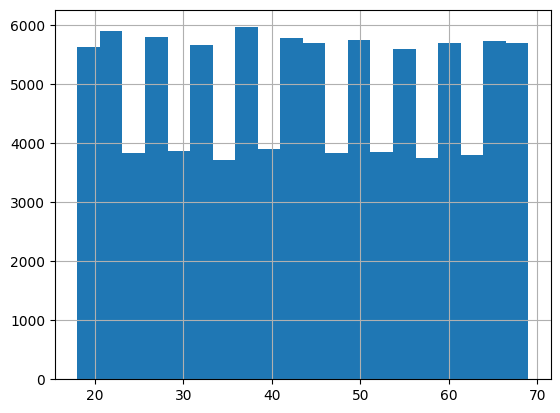

In [13]:
# 'invoice_date' 열을 datetime 형식으로 변환
df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')

# 'invoice_date'에서 월과 연도 추출
df['invoice_month'] = df['invoice_date'].dt.month
df['invoice_year'] = df['invoice_date'].dt.year

# 성별 및 카테고리별 평균 수량과 총 가격 분석
category_gender_stats = df.groupby(['category', 'gender'])[['quantity', 'price']].agg({'quantity': 'mean', 'price': 'sum'})

# 쇼핑몰별 총 매출 계산
total_sales_per_mall = df.groupby('shopping_mall')['price'].sum().sort_values(ascending=False)

# 나이 분포 탐색
age_distribution = df['age'].hist(bins=20)

# 가장 일반적인 결제 방법 식별
popular_payment_method = df['payment_method'].mode().values[0]

## Step 10: 시계열 GroupBy

데이터셋이 시간 관련 정보를 포함하고 있다면, 시계열 데이터의 맥락에서 GroupBy의 기능을 탐구합니다.
시간 기반 열에 GroupBy 작업을 적용하는 방법을 보여주고, 다양한 시간 주기로 재샘플링하는 기술을 탐구합니다.
이 단계는 시간 기반 데이터 작업을 하는 사람들에게 중요하며, 시간 인식 분석과 인사이트의 잠재력을 드러냅니다.


In [14]:
# 'invoice_date'는 타임스탬프를 포함하는 열입니다
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# 월별로 그룹화하고 'price' 열의 합계를 계산합니다
time_grouped = df.groupby(pd.Grouper(key='invoice_date', freq='M'))['price'].sum()
df['invoice_date']

<ipython-input-14-526363e7ab6e>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_grouped = df.groupby(pd.Grouper(key='invoice_date', freq='M'))['price'].sum()


,invoice_date
0,2022-05-08
1,2021-12-12
2,2021-09-11
3,NaT
4,NaT
...,...
99452,NaT
99453,NaT
99454,NaT
99455,NaT


In [15]:
time_grouped

,price
invoice_date,
2021-01-31,961433.99
2021-02-28,1008348.21
2021-03-31,1099307.80
2021-04-30,1082387.50
2021-05-31,1040528.62
2021-06-30,1042822.81
2021-07-31,1020653.35
2021-08-31,1013145.62
2021-09-30,980300.03


## Step 11: 시각화

GroupBy 튜토리얼을 풍부하게 만들기 위해 인사이트를 생생하게 전달하는 시각화를 활용합니다.
Matplotlib이나 Seaborn을 사용하여 GroupBy 작업의 결과를 생동감 있게 표현하는 플롯을 생성합니다.
막대 차트, 선 그래프 또는 히트맵 등 다양한 시각화를 통해 결과의 해석 가능성을 향상시켜 데이터 패턴을 청중이 더 쉽게 이해할 수 있도록 합니다.


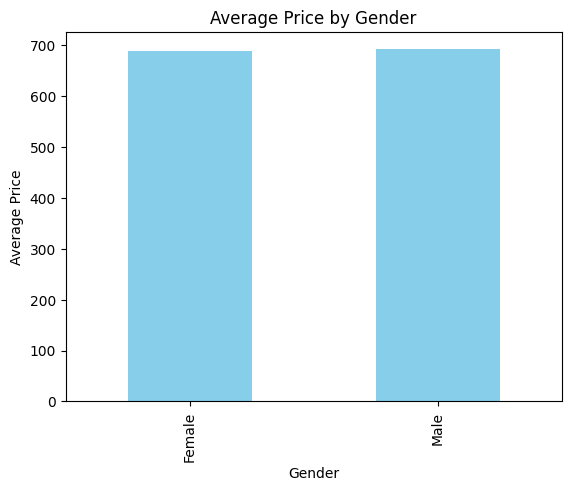

In [18]:
# Change it to the column you are interested in
grouped_data = df.groupby('gender')['price'].mean()

# Plotting
grouped_data.plot(kind='bar', color='skyblue')
plt.title('Average Price by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Price')
plt.show()

## Step 12: 실제 응용

이 단계에서는 데이터 과학 분야에서 GroupBy의 실제 응용 사례를 탐구합니다.
GroupBy 기술이 다양한 산업에서 의미 있는 인사이트를 도출하는 방법에 대한 구체적인 예를 논의합니다.
비즈니스 분석, 과학 연구 또는 데이터셋과 관련된 어떤 분야에서든 시나리오를 설명합니다.
GroupBy의 실제 응용을 이해하는 것은 데이터 분석의 넓은 분야에서 그 중요성을 확고히 하는 데 도움이 됩니다.
GroupBy가 복잡한 문제를 해결하고 다양한 데이터셋에서 귀중한 지식을 추출하는 데 얼마나 혁신적인 역할을 했는지에 대한 통찰력을 제공합니다.
이 단계는 이론적 지식과 실제적인 영향 간의 격차를 줄이고, 독자들이 자신의 프로젝트에 GroupBy 기술을 적용하도록 영감을 주는 것을 목표로 합니다.


## Step 13: 결론

GroupBy 튜토리얼의 결론에 도달하면서 우리가 데이터 분석의 역동적인 세계로 들어간 여정을 되돌아봅니다.
튜토리얼 동안 GroupBy의 기본 개념과 다양한 응용, 고급 기술을 탐구했습니다.
GroupBy는 데이터 과학자의 도구 상자에서 중요한 기초로 작용하여 복잡한 데이터셋에서 귀중한 인사이트를 조직하고 추출할 수 있게 합니다.
핵심 요점을 요약하고 데이터 조작 분야에서 GroupBy의 중요성을 강조합니다.
효율적인 데이터 요약에서의 역할을 다시 강조하고, 정보에 기반한 의사결정을 촉진하는 역할을 부각시킵니다.
독자들이 여기서 얻은 지식을 자신의 프로젝트에 적용하여 데이터셋에 대한 더 깊은 이해와 숨겨진 패턴을 발견하도록 격려합니다.
결론적으로, GroupBy가 원시 데이터를 실행 가능한 지식으로 변환하는 변혁적인 잠재력을 표현하고, 개인들이 데이터 기반 결정을 내릴 수 있도록 힘을 실어줍니다.


## Step 14: 연습 도전 과제

GroupBy 튜토리얼의 결론에 도달하면서 우리가 데이터 분석의 역동적인 세계로 들어간 여정을 되돌아봅니다.
튜토리얼 동안 GroupBy의 기본 개념과 다양한 응용, 고급 기술을 탐구했습니다.
GroupBy는 데이터 과학자의 도구 상자에서 중요한 기초로 작용하여 복잡한 데이터셋에서 귀중한 인사이트를 조직하고 추출할 수 있게 합니다.
핵심 요점을 요약하고 데이터 조작 분야에서 GroupBy의 중요성을 강조합니다.
효율적인 데이터 요약에서의 역할을 다시 강조하고, 정보에 기반한 의사결정을 촉진하는 역할을 부각시킵니다.
독자들이 여기서 얻은 지식을 자신의 프로젝트에 적용하여 데이터셋에 대한 더 깊은 이해와 숨겨진 패턴을 발견하도록 격려합니다.
결론적으로, GroupBy가 원시 데이터를 실행 가능한 지식으로 변환하는 변혁적인 잠재력을 표현하고, 개인들이 데이터 기반 결정을 내릴 수 있도록 힘을 실어줍니다.

-------------------------------------------------------------------------------------------------------
기본 GroupBy 연습:
•	선택한 범주형 열로 데이터셋을 그룹화합니다.
•	그룹화된 데이터에 대해 다양한 집계 함수(예: 평균, 합계, 개수)를 적용합니다

-------------------------------------------------------------------------------------------------------
다중 열 GroupBy 도전 과제:
•	두 개 이상의 열을 선택하여 그룹화합니다.
•	각 열에 사용자 정의 집계 함수를 적용합니다.
•	결과를 새로운 DataFrame으로 결합합니다.

-------------------------------------------------------------------------------------------------------
시계열 GroupBy 연습:
•	데이터셋에 적용 가능한 경우, 열을 날짜/시간 형식으로 변환합니다.
•	시간 관련 열로 데이터를 그룹화하고 시간 기반 집계 함수(예: 재샘플링)를 적용합니다.

-------------------------------------------------------------------------------------------------------
시각화 도전 과제:
•	GroupBy 작업의 결과를 나타내는 시각화를 생성합니다.
•	인사이트를 효과적으로 보여주기 위해 다양한 유형의 플롯(예: 막대 차트, 선 그래프)을 실험합니다.

-------------------------------------------------------------------------------------------------------
실제 응용 연습:
•	데이터셋과 관련된 특정 산업이나 분야를 식별합니다.
•	GroupBy 기술을 사용하여 해결할 수 있는 문제를 공식화합니다.
•	GroupBy 작업을 적용하여 의미 있는 인사이트를 도출합니다.
독자들이 이러한 연습과 도전 과제를 통해 GroupBy에 대한 숙련도를 강화하도록 격려합니다.
필요한 경우 해결책이나 힌트를 제공하여 올바른 방향으로 안내합니다.
이러한 상호작용 요소는 얻은 지식이 이론에 그치지 않고 다양한 시나리오에서 적용될 수 있도록 보장합니다. 행복한 코딩 되세요!



## Step 15: References

##### McKinney, W. (2010). Data Structures for Statistical Computing in Python. In Proceedings of the 9th Python in Science Conference (pp. 51-56).

##### VanderPlas, J. (2016). Python Data Science Handbook: Essential Tools for Working with Data. O'Reilly Media.

##### Wes McKinney et al. (2021). Pandas: powerful data structures for data analysis, version 1.3.3. Zenodo.

##### Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90–95.

##### Reback, J., McKinney, W., & others. (2021). Pandas-Dev/pandas: Pandas 1.3.3.

##### McKinney, W., & others. (2011). pandas: a Foundational Python Library for Data Analysis and Statistics. Python for High Performance and Scientific Computing, 14–16.

##### Millman, K. J., & Aivazis, M. (2011). Python for Scientists and Engineers. Computing in Science & Engineering, 13(2), 9–12.

##### Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362.

##### McKinney, W. (2018). Python for Data Analysis: Data Wrangling with Pandas, NumPy, and IPython. O'Reilly Media.

##### Perez, F., & Granger, B. E. (2007). IPython: A System for Interactive Scientific Computing. Computing in Science & Engineering, 9(3), 21–29.

## -----------------------------------------------------------------------------------
## ------------------------------------ Projects ------------------------------------
## -----------------------------------------------------------------------------------

### Project 1: 월별 판매 추세
- **목표**: 월별 판매 추세를 분석하여 패턴과 계절성을 식별합니다.
- **데이터셋**: `sales_data.csv` 파일을 가정하며, 열은 Date와 Sales로 구성됩니다


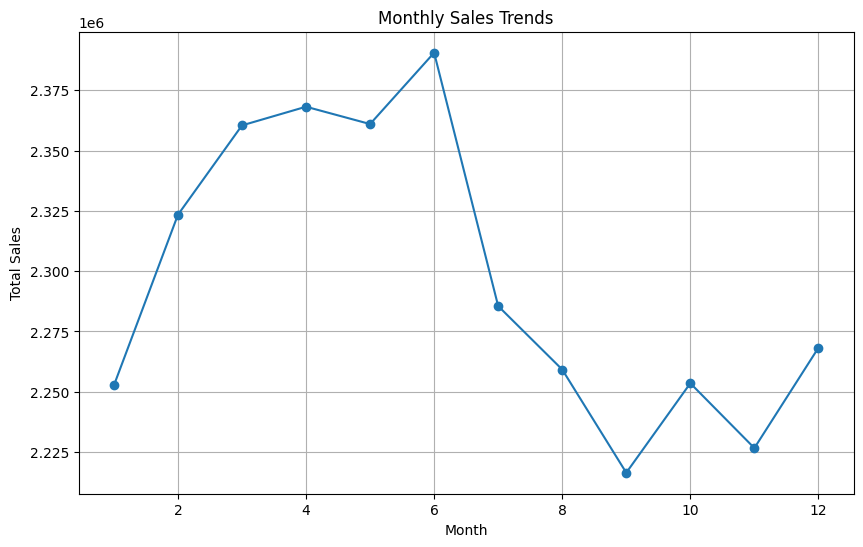

In [19]:
# 1단계: 'invoice_date' 열을 datetime 형식으로 변환
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# 2단계: 월을 위한 새로운 열 생성
df['month'] = df['invoice_date'].dt.month

# 3단계: 월별로 그룹화하고 각 월의 총 매출 계산
monthly_sales = df.groupby('month')['price'].sum()

# 4단계: 월별 매출 추세를 시각화
plt.figure(figsize=(10, 6))
monthly_sales.plot(marker='o')
plt.title('Monthly Sales Trends')  # 월별 매출 추세
plt.xlabel('Month')  # 월
plt.ylabel('Total Sales')  # 총 매출
plt.grid(True)
plt.show()

### Project 2: 프로젝트 2: 평균 일일 온도
- **목표**: 시간에 따른 평균 일일 온도 추세를 분석합니다.
- **데이터셋**: `temperature_data.csv` 파일을 가정하며, 열은 Date와 Temperature로 구성됩니다.


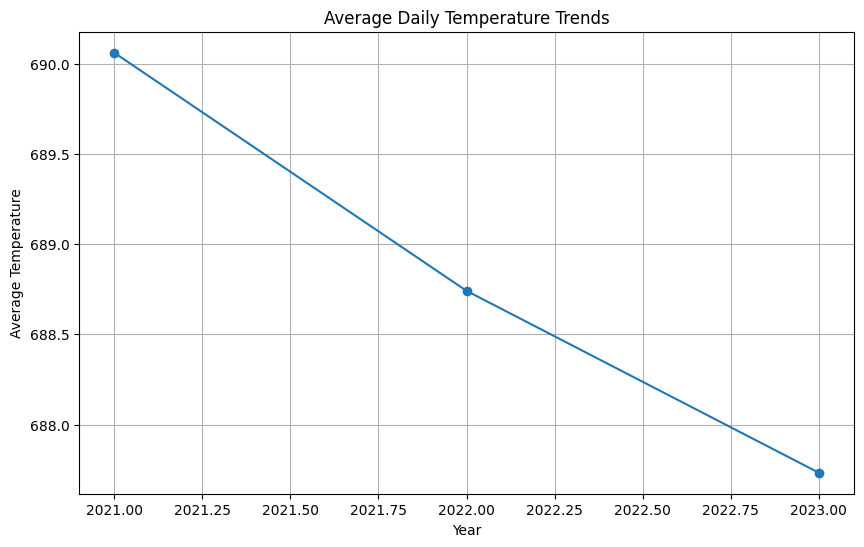

In [20]:
# 1단계: 데이터셋 로드
temperature_data = pd.read_csv('/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv')

# 2단계: 'invoice_date' 열을 올바른 형식으로 datetime 형식으로 변환
temperature_data['invoice_date'] = pd.to_datetime(temperature_data['invoice_date'], format='%d/%m/%Y')

# 3단계: 연도를 위한 새로운 열 생성
temperature_data['year'] = temperature_data['invoice_date'].dt.year

# 4단계: 연도별로 그룹화하고 각 연도의 평균 일일 온도 계산
average_daily_temperature = temperature_data.groupby('year')['price'].mean()

# 5단계: 평균 일일 온도 추세를 시각화
plt.figure(figsize=(10, 6))
average_daily_temperature.plot(marker='o')
plt.title('Average Daily Temperature Trends')  # 평균 일일 온도 추세
plt.xlabel('Year')  # 연도
plt.ylabel('Average Temperature')  # 평균 온도
plt.grid(True)
plt.show()

### 프로젝트 3: 장르별 영화 통계
**목표**: 다양한 영화 장르에 대한 통계를 분석하고 비교합니다.
- **데이터셋**: `movies_data.csv` 파일을 가정하며, 열은 MovieTitle, Genre, ReleaseYear, BoxOfficeRevenue로 구성됩니다.


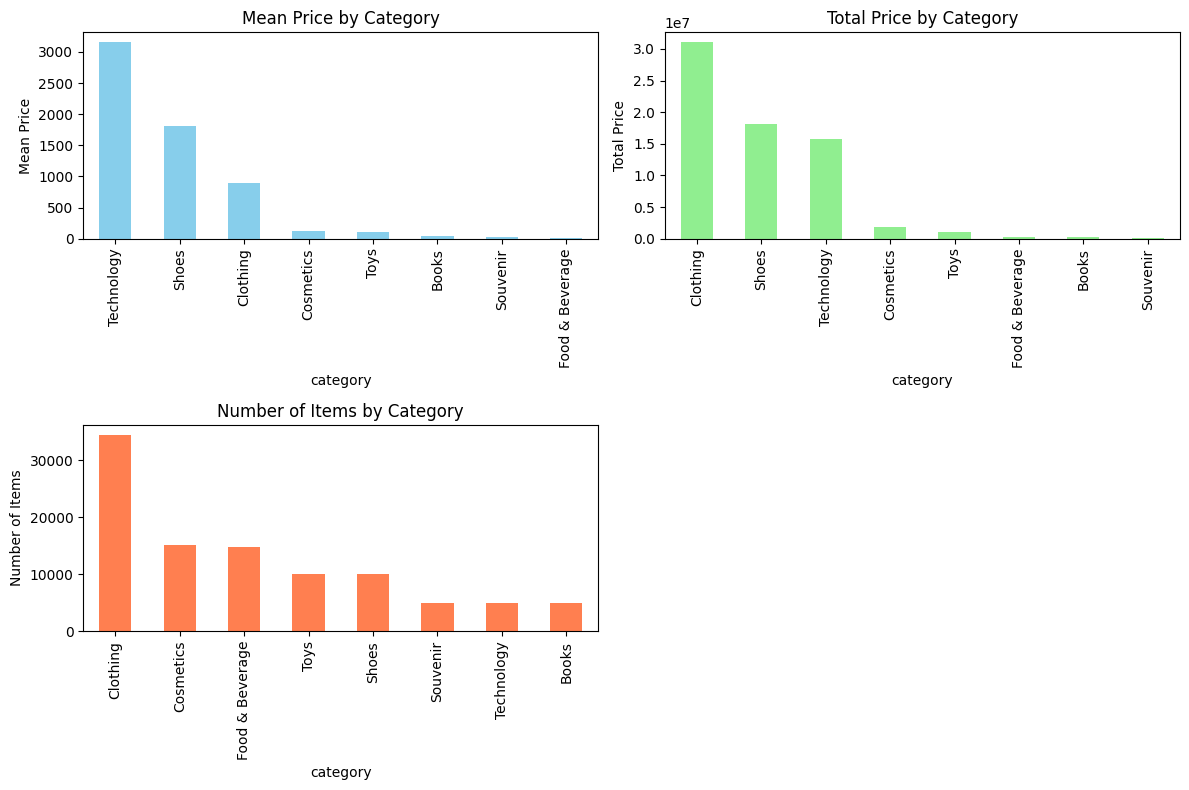

In [21]:
# 1단계: 데이터셋 로드
movies_data = pd.read_csv('/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv')

# 2단계: 카테고리별로 그룹화하고 통계(평균, 합계, 개수) 계산
category_statistics = movies_data.groupby('category')['price'].agg(['mean', 'sum', 'count'])

# 3단계: 통계 시각화
plt.figure(figsize=(12, 8))

# 카테고리별 평균 가격에 대한 막대 그래프
plt.subplot(2, 2, 1)
category_statistics['mean'].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Mean Price by Category')  # 카테고리별 평균 가격
plt.ylabel('Mean Price')  # 평균 가격

# 카테고리별 총 가격에 대한 막대 그래프
plt.subplot(2, 2, 2)
category_statistics['sum'].sort_values(ascending=False).plot(kind='bar', color='lightgreen')
plt.title('Total Price by Category')  # 카테고리별 총 가격
plt.ylabel('Total Price')  # 총 가격

# 카테고리별 아이템 수에 대한 막대 그래프
plt.subplot(2, 2, 3)
category_statistics['count'].sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title('Number of Items by Category')  # 카테고리별 아이템 수
plt.ylabel('Number of Items')  # 아이템 수

plt.tight_layout()
plt.show()

###프로젝트 4: 직원 재직 기간 분석
**목표**: 회사 내 직원 재직 기간의 분포를 분석합니다.
- **데이터셋**: `employee_data.csv` 파일을 가정하며, 열은 EmployeeID, JoinDate, CurrentDate로 구성됩니다.


Index(['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity',
       'price', 'payment_method', 'invoice_date', 'shopping_mall'],
      dtype='object')


<ipython-input-22-8797bfcbbd53>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employee_data['Tenure'] = (current_date - employee_data['invoice_date']).dt.days
<ipython-input-22-8797bfcbbd53>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employee_data['Tenure Bin'] = pd.cut(employee_data['Tenure'], bins=bins)
<ipython-input-22-8797bfcbbd53>:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

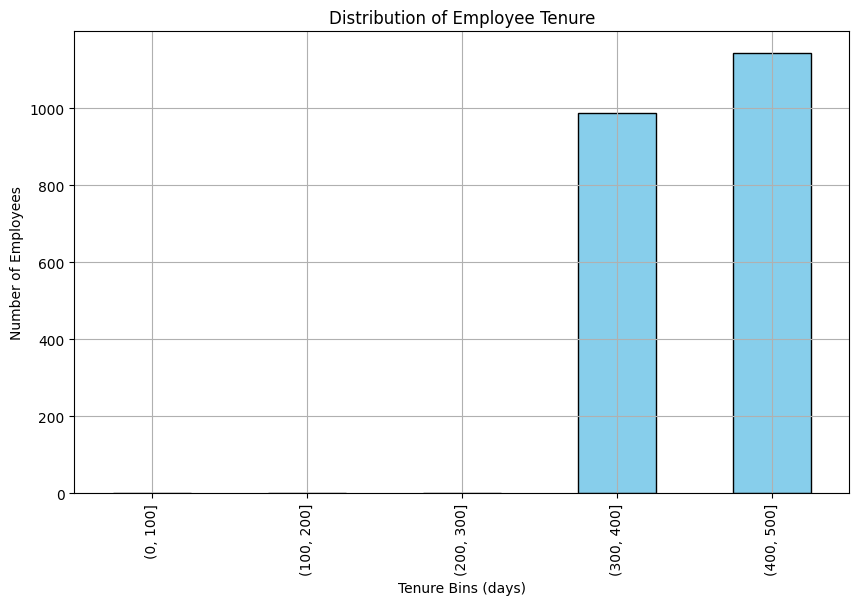

In [22]:
# 1단계: 데이터셋 로드
employee_data = pd.read_csv('/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv')

# 열 이름을 출력하여 정확성을 확인
print(employee_data.columns)

# 2단계: 'invoice_date' 열을 datetime 형식으로 변환
try:
    employee_data['invoice_date'] = pd.to_datetime(employee_data['invoice_date'], errors='coerce')
except KeyError as e:
    print(f"Error: {e} 열을 찾을 수 없습니다. 데이터셋의 열 이름을 확인하세요.")

# 3단계: 'invoice_date'에서 결측값이 있는 행 삭제
employee_data = employee_data.dropna(subset=['invoice_date'])

# 4단계: 각 직원의 근속 기간 계산
# 단순화를 위해 'invoice_date'를 입사일로 가정하고, 현재 날짜를 오늘로 설정
current_date = pd.to_datetime('today')
employee_data['Tenure'] = (current_date - employee_data['invoice_date']).dt.days

# 5단계: 'Tenure'를 구간으로 나누고, 구간별로 그룹화하여 분포 시각화
bins = [0, 100, 200, 300, 400, 500]  # 필요에 따라 구간 경계를 조정
employee_data['Tenure Bin'] = pd.cut(employee_data['Tenure'], bins=bins)
plt.figure(figsize=(10, 6))
employee_data.groupby('Tenure Bin').size().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Employee Tenure')  # 직원 근속 기간 분포
plt.xlabel('Tenure Bins (days)')  # 근속 기간 구간 (일)
plt.ylabel('Number of Employees')  # 직원 수
plt.grid(True)
plt.show()

### 프로젝트 5: 카테고리별 인기 상품
- **목표**: 각 제품 카테고리 내에서 인기 상품을 식별하고 분석합니다.
- **데이터셋**: `products_data.csv` 파일을 가정하며, 열은 ProductID, ProductName, Category, SalesQuantity로 구성됩니다.


Index(['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity',
       'price', 'payment_method', 'invoice_date', 'shopping_mall'],
      dtype='object')


<ipython-input-23-25d94307cd00>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_products_by_category = AB_dataset.groupby('category').apply(lambda x: x.nlargest(1, 'quantity'))


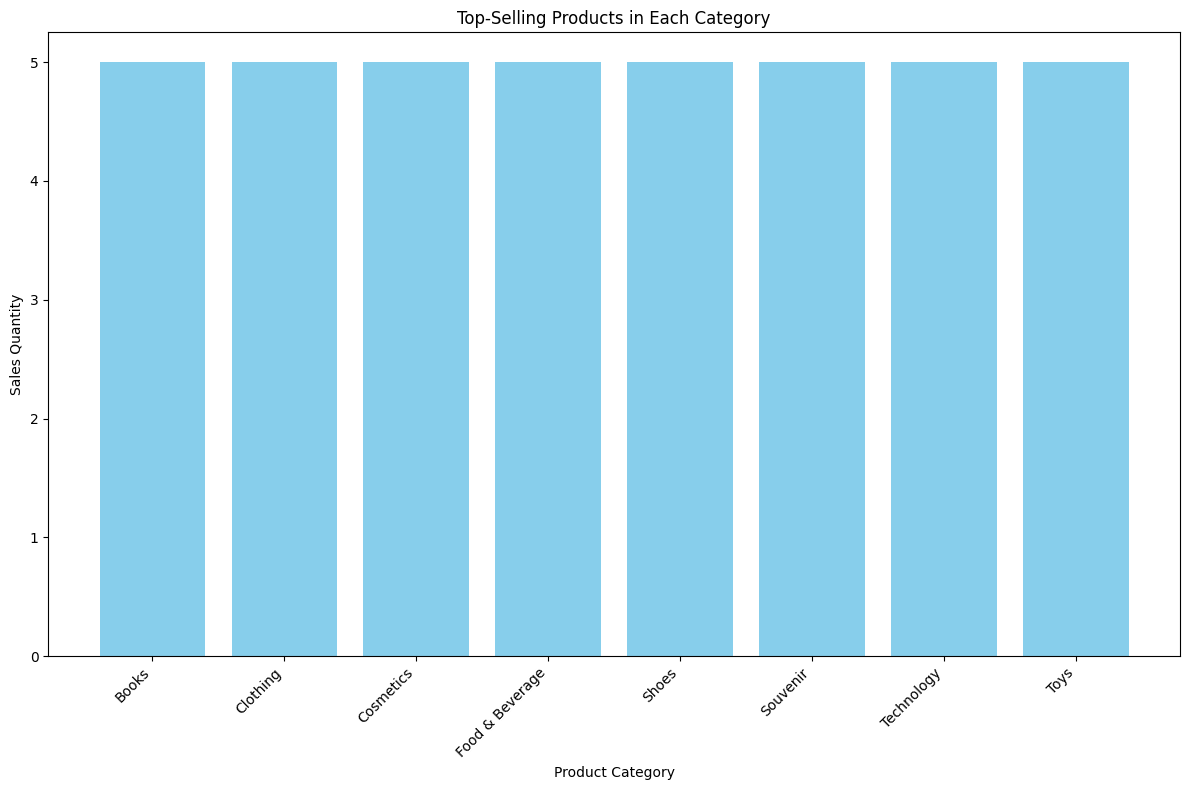

In [23]:
# 1단계: 데이터셋 로드
AB_dataset = pd.read_csv('/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv')

# 열 이름을 출력하여 정확성을 확인
print(AB_dataset.columns)

# 2단계: 카테고리별로 그룹화하고 각 카테고리에서 가장 많이 팔린 제품 찾기
top_products_by_category = AB_dataset.groupby('category').apply(lambda x: x.nlargest(1, 'quantity'))

# 3단계: 각 카테고리에서 가장 많이 팔린 제품 시각화
plt.figure(figsize=(12, 8))

# 판매 수량에 대한 막대 그래프
plt.bar(top_products_by_category['category'], top_products_by_category['quantity'], color='skyblue')
plt.title('Top-Selling Products in Each Category')  # 각 카테고리에서 가장 많이 팔린 제품
plt.xlabel('Product Category')  # 제품 카테고리
plt.ylabel('Sales Quantity')  # 판매 수량
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 프로젝트 6: 소셜 미디어 게시물 빈도
- **목표**: 시간에 따른 소셜 미디어 게시물의 빈도를 분석합니다.
- **데이터셋**: `social_media_data.csv` 파일을 가정하며, 열은 PostID, PostDate, Likes로 구성됩니다.


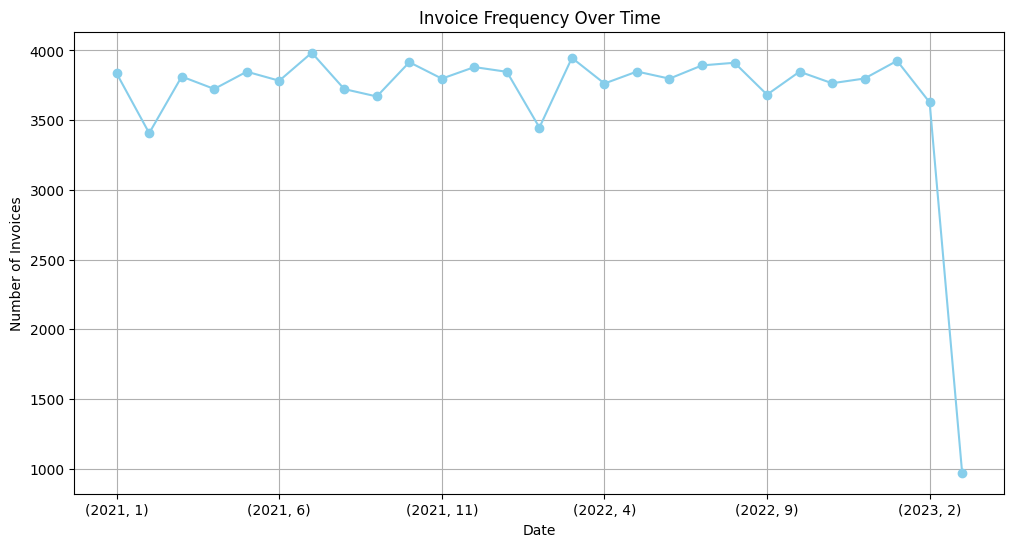

In [24]:
# 1단계: 데이터셋 로드
customer_shopping_data = pd.read_csv('/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv')

# 2단계: 'invoice_date' 열을 올바른 형식으로 datetime 형식으로 변환
customer_shopping_data['invoice_date'] = pd.to_datetime(customer_shopping_data['invoice_date'], format='%d/%m/%Y')

# 3단계: 그룹화를 위해 'invoice_date'에서 월과 연도 추출
customer_shopping_data['Month'] = customer_shopping_data['invoice_date'].dt.month
customer_shopping_data['Year'] = customer_shopping_data['invoice_date'].dt.year

# 4단계: 연도와 월별로 그룹화하고 송장 수 계산
invoice_frequency = customer_shopping_data.groupby(['Year', 'Month']).size()

# 5단계: 시간에 따른 송장 수 시각화
plt.figure(figsize=(12, 6))
invoice_frequency.plot(marker='o', linestyle='-', color='skyblue')
plt.title('Invoice Frequency Over Time')  # 시간에 따른 송장 수
plt.xlabel('Date')  # 날짜
plt.ylabel('Number of Invoices')  # 송장 수
plt.grid(True)
plt.show()

### 프로젝트 7: 분기별 재무 인사이트
- **목표**: 재무 데이터를 분석하고 분기별 인사이트를 도출합니다.
- **데이터셋**: `financial_data.csv` 파일을 가정하며, 열은 Date, Revenue, Expenses로 구성됩니다.



<Figure size 1200x600 with 0 Axes>

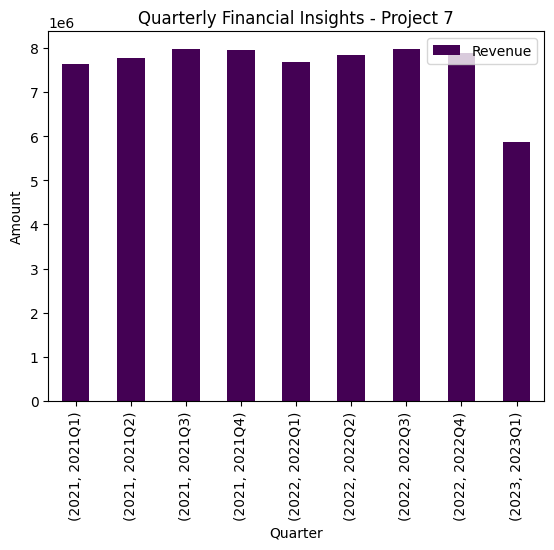

In [25]:
# 1단계: 데이터셋 로드
financial_data = pd.read_csv('/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv')

# 2단계: 'invoice_date' 열을 datetime 형식으로 변환
financial_data['invoice_date'] = pd.to_datetime(financial_data['invoice_date'], format='%d/%m/%Y')

# 3단계: 그룹화를 위해 'invoice_date'에서 분기와 연도 추출
financial_data['Quarter'] = financial_data['invoice_date'].dt.to_period('Q')
financial_data['Year'] = financial_data['invoice_date'].dt.year

# 4단계: 분기 및 연도별로 그룹화하고 총 수익 및 비용 계산
quarterly_financials = financial_data.groupby(['Year', 'Quarter']).agg({'price': 'sum', 'category': 'sum'})

# 6단계: 분기별 재무 인사이트 시각화
plt.figure(figsize=(12, 6))
quarterly_financials.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Quarterly Financial Insights - Project 7')  # 분기별 재무 인사이트 - 프로젝트 7
plt.xlabel('Quarter')  # 분기
plt.ylabel('Amount')  # 금액
plt.legend(['Revenue', 'Expenses'])  # 수익, 비용
plt.show()

### 프로젝트 8: 웹사이트 사용자 활동
- **목표**: 시간에 따른 웹사이트 사용자 활동을 분석하고 시각화합니다.
- **데이터셋**: `website_activity_data.csv` 파일을 가정하며, 열은 UserID, Timestamp, PageViews로 구성됩니다.


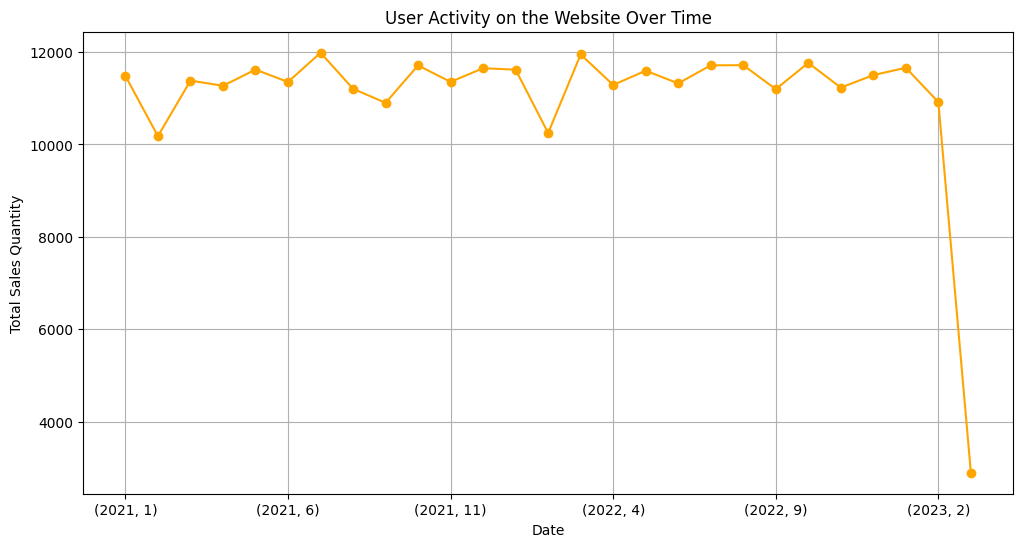

In [26]:
# 1단계: 데이터셋 로드
customer_shopping_data = pd.read_csv('/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv')

# 2단계: 'invoice_date' 열을 datetime 형식으로 변환
customer_shopping_data['invoice_date'] = pd.to_datetime(customer_shopping_data['invoice_date'], errors='coerce', dayfirst=True)

# 3단계: 그룹화를 위해 'invoice_date'에서 월과 연도 추출
customer_shopping_data['Month'] = customer_shopping_data['invoice_date'].dt.month
customer_shopping_data['Year'] = customer_shopping_data['invoice_date'].dt.year

# 4단계: 연도와 월별로 그룹화하고 총 판매 수량 계산
monthly_sales_quantity = customer_shopping_data.groupby(['Year', 'Month'])['quantity'].sum()

# 5단계: 시간에 따른 웹사이트 사용자 활동 시각화
plt.figure(figsize=(12, 6))
monthly_sales_quantity.plot(marker='o', linestyle='-', color='orange')
plt.title('User Activity on the Website Over Time')  # 시간에 따른 웹사이트 사용자 활동
plt.xlabel('Date')  # 날짜
plt.ylabel('Total Sales Quantity')  # 총 판매 수량
plt.grid(True)
plt.show()

### 프로젝트 9: 주식 가격 변동성
- **목표**: 시간에 따른 주식 가격의 변동성을 분석합니다.
- **데이터셋**: `stock_prices_data.csv` 파일을 가정하며, 열은 Date, StockSymbol, ClosingPrice로 구성됩니다.


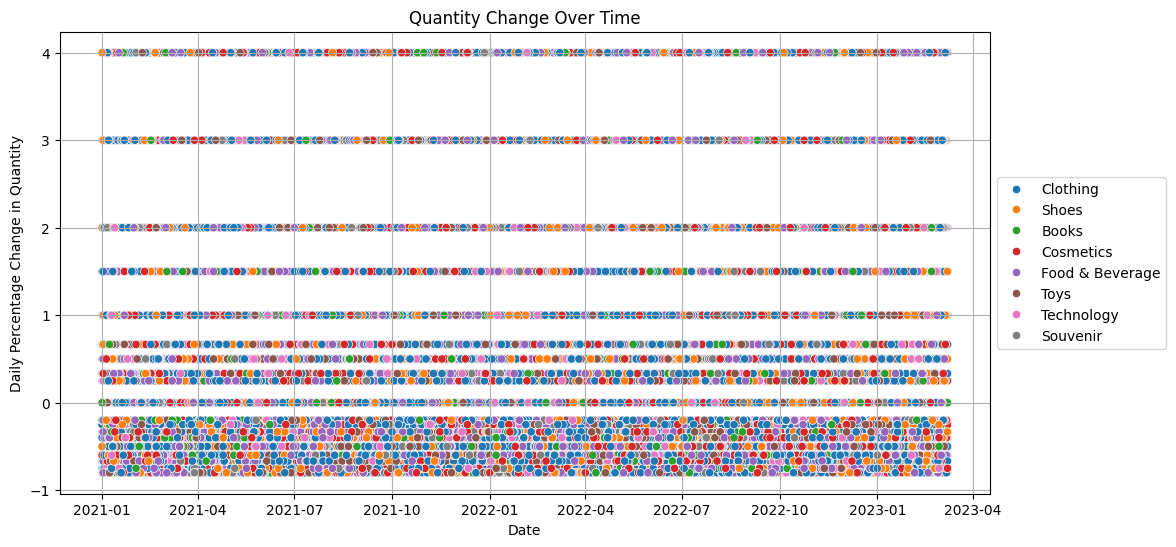

In [27]:
# 1단계: 데이터셋 로드
customer_shopping_data = pd.read_csv('/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv')

# 2단계: 'invoice_date' 열을 datetime 형식으로 변환
customer_shopping_data['invoice_date'] = pd.to_datetime(customer_shopping_data['invoice_date'], errors='coerce', dayfirst=True)

# 3단계: 수량의 일일 백분율 변화 계산
customer_shopping_data['QuantityChange'] = customer_shopping_data.groupby('category')['quantity'].pct_change()

# 4단계: Seaborn을 사용하여 시간에 따른 수량 변화를 산점도로 시각화
plt.figure(figsize=(12, 6))
sns.scatterplot(x='invoice_date', y='QuantityChange', hue='category', data=customer_shopping_data, marker='o')
plt.title('Quantity Change Over Time')  # 시간에 따른 수량 변화
plt.xlabel('Date')  # 날짜
plt.ylabel('Daily Percentage Change in Quantity')  # 일일 수량 백분율 변화
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

### 프로젝트 10: 주간 웹사이트 트래픽 패턴
- **목표**: 웹사이트 트래픽의 주간 패턴을 분석하고 시각화합니다.
- **데이터셋**: `website_traffic_data.csv` 파일을 가정하며, 열은 Timestamp와 PageViews로 구성됩니다.


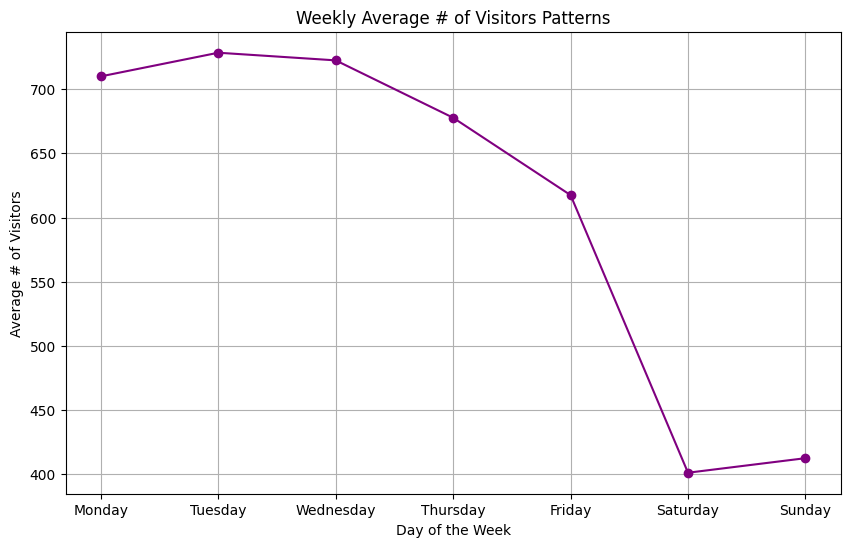

In [29]:
# 1단계: 데이터셋 로드
website_traffic_data = pd.read_csv('/kaggle/input/lacity.org-website-traffic/lacity.org-website-traffic.csv')

# 2단계: 'Date' 열을 datetime 형식으로 변환
website_traffic_data['Date'] = pd.to_datetime(website_traffic_data['Date'])

# 3단계: 그룹화를 위해 'Date'에서 요일 추출
website_traffic_data['DayOfWeek'] = website_traffic_data['Date'].dt.day_name()

# 4단계: 요일별로 그룹화하고 평균 방문자 수 계산
weekly_visitors = website_traffic_data.groupby('DayOfWeek')['# of Visitors'].mean()

# 5단계: 주간 방문자 패턴 시각화
plt.figure(figsize=(10, 6))
weekly_visitors.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(marker='o', linestyle='-', color='purple')
plt.title('Weekly Average # of Visitors Patterns')  # 주간 평균 방문자 패턴
plt.xlabel('Day of the Week')  # 요일
plt.ylabel('Average # of Visitors')  # 평균 방문자 수
plt.grid(True)
plt.show()

### 프로젝트 11: 의료 분야 환자 연령 그룹
- **목표**: 환자를 다양한 연령 그룹으로 분류하여 의료 인사이트를 분석합니다.
- **데이터셋**: `healthcare_data.csv` 파일을 가정하며, 열은 PatientID, DateOfBirth, MedicalCondition으로 구성됩니다.


<ipython-input-30-0b0a7ec16fbd>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diabetes_data.groupby('AgeGroup').size().plot(kind='bar', color='salmon')


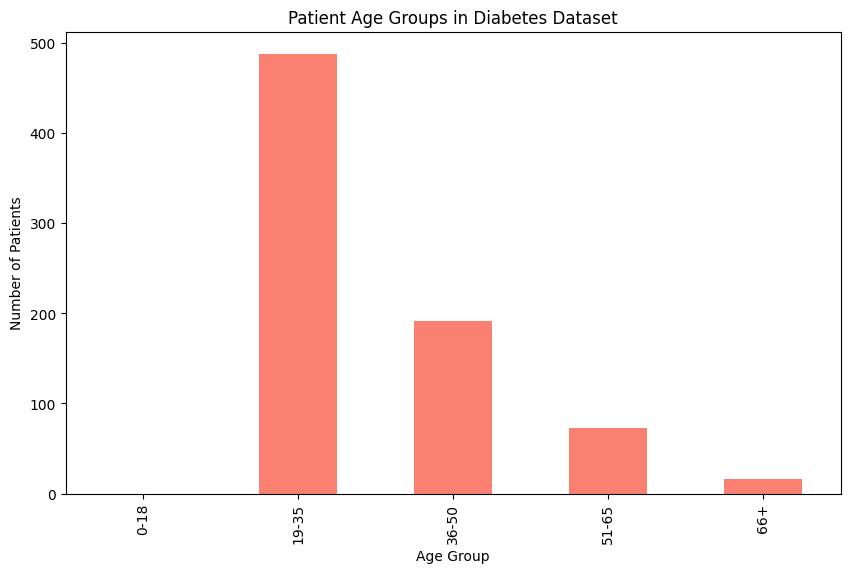

In [30]:
# 1단계: 데이터셋 로드
diabetes_data = pd.read_csv('/kaggle/input/diabetes-dataset/diabetes.csv')

# 2단계: 환자를 연령 그룹으로 분류
age_bins = [0, 18, 35, 50, 65, 100]
age_labels = ['0-18', '19-35', '36-50', '51-65', '66+']
diabetes_data['AgeGroup'] = pd.cut(diabetes_data['Age'], bins=age_bins, labels=age_labels, right=False)

# 3단계: 'AgeGroup'별로 그룹화하고 분포 시각화
plt.figure(figsize=(10, 6))
diabetes_data.groupby('AgeGroup').size().plot(kind='bar', color='salmon')
plt.title('Patient Age Groups in Diabetes Dataset')  # 당뇨병 데이터셋의 환자 연령 그룹
plt.xlabel('Age Group')  # 연령 그룹
plt.ylabel('Number of Patients')  # 환자 수
plt.show()

### 프로젝트 12: 베스트셀러 전자상거래 카테고리
- **목표**: 전자상거래 데이터셋에서 베스트셀러 카테고리를 식별하고 분석합니다.
- **데이터셋**: `ecommerce_data.csv` 파일을 가정하며, 열은 OrderID, ProductCategory, OrderAmount로 구성됩니다.


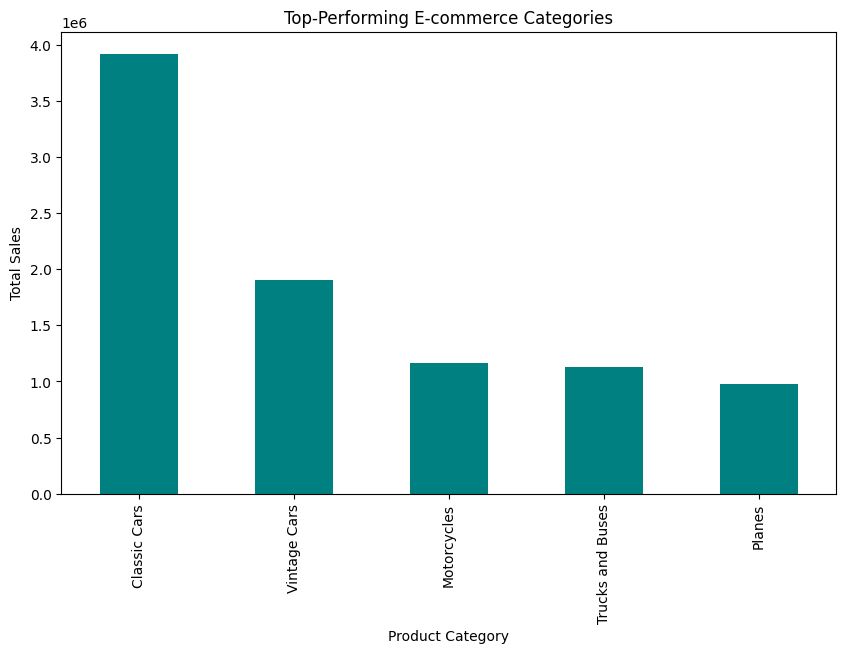

In [31]:
# 1단계: 올바른 인코딩으로 데이터셋 로드
ecommerce_data = pd.read_csv('/kaggle/input/sample-sales-data/sales_data_sample.csv', encoding='latin1')

# 2단계: 올바른 열('PRODUCTLINE')로 그룹화하고 총 판매액 계산
category_sales = ecommerce_data.groupby('PRODUCTLINE')['SALES'].sum()

# 3단계: 최상위 성과 카테고리 식별
top_categories = category_sales.nlargest(5)

# 4단계: 최상위 성과 전자상거래 카테고리 시각화
plt.figure(figsize=(10, 6))
top_categories.plot(kind='bar', color='teal')
plt.title('Top-Performing E-commerce Categories')  # 최상위 성과 전자상거래 카테고리
plt.xlabel('Product Category')  # 제품 카테고리
plt.ylabel('Total Sales')  # 총 판매액
plt.show()

###프로젝트 13: 설문 조사 감정 분석
- **목표**: 설문 조사 데이터셋에서 감정을 분석하여 참가자 피드백을 이해합니다.
- **데이터셋**: `survey_data.csv` 파일을 가정하며, 열은 ParticipantID와 Feedback으로 구성됩니다.


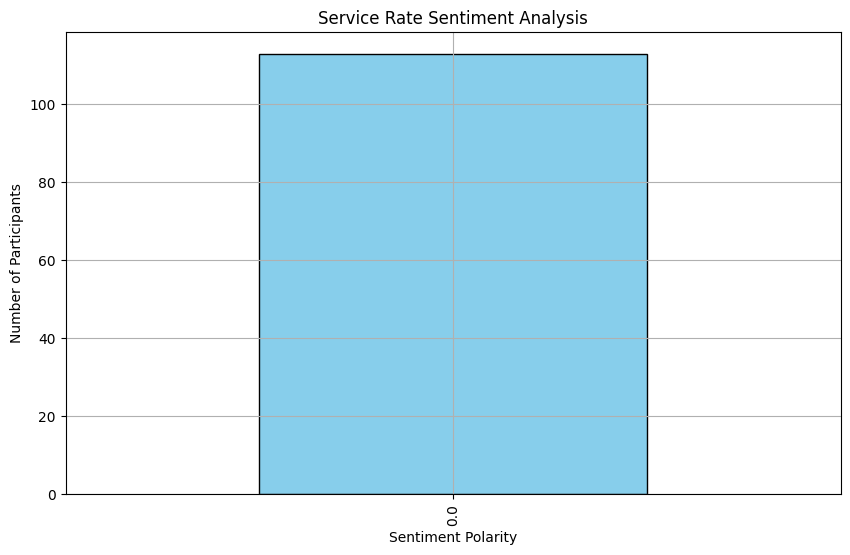

In [32]:
# 1단계: 데이터셋 로드
survey_data = pd.read_csv('/kaggle/input/starbucks-customer-retention-malaysia-survey/Starbucks satisfactory survey encode cleaned.csv')

# 2단계: 'serviceRate' 열에 대해 감정 분석 수행
survey_data['ServiceSentiment'] = survey_data['serviceRate'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# 3단계: 'ServiceSentiment'로 그룹화하고 분포 시각화
plt.figure(figsize=(10, 6))
survey_data.groupby('ServiceSentiment').size().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Service Rate Sentiment Analysis')  # 서비스 평가 감정 분석
plt.xlabel('Sentiment Polarity')  # 감정 극성
plt.ylabel('Number of Participants')  # 참가자 수
plt.grid(True)
plt.show()

### 프로젝트 14: 웹 페이지 클릭스트림 분석
- **목표**: 웹사이트의 클릭스트림 데이터를 분석하여 사용자 탐색 패턴을 이해합니다.
- **데이터셋**: `clickstream_data.csv` 파일을 가정하며, 열은 UserID, Timestamp, PageVisited로 구성됩니다.


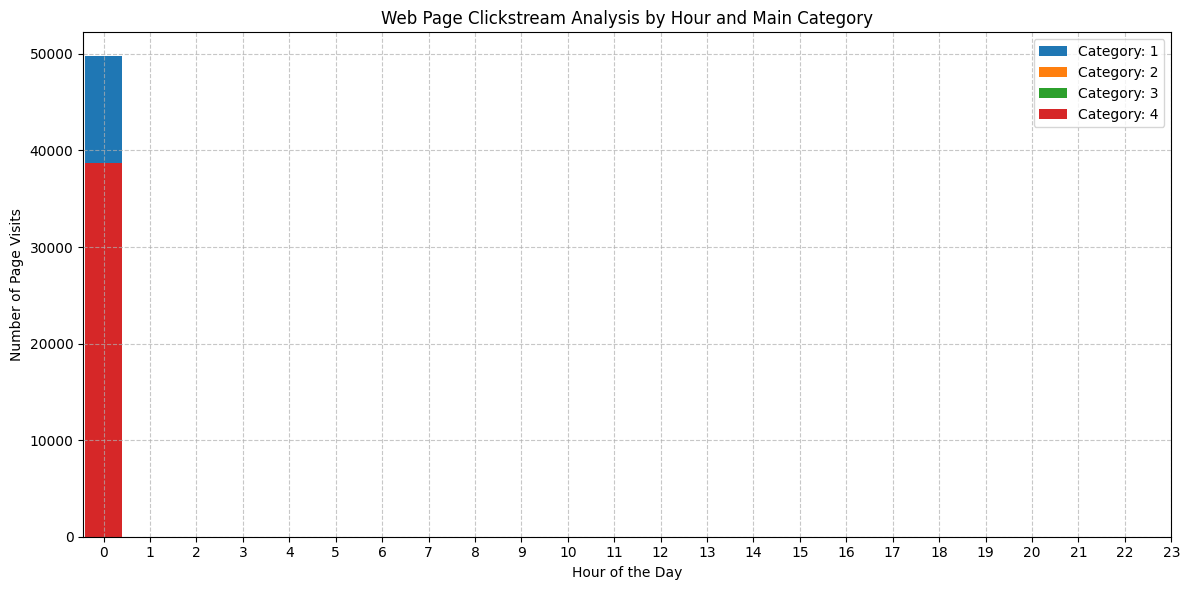

In [33]:
# 1단계: 올바른 구분자와 헤더로 데이터셋 로드
clickstream_data = pd.read_csv('/kaggle/input/clickstream-data-for-online-shopping/e-shop clothing 2008.csv', delimiter=';', header=0)

# 2단계: 그룹화를 위해 'Timestamp'에서 시간 추출
clickstream_data['Timestamp'] = pd.to_datetime(clickstream_data[['year', 'month', 'day']])
# 새로 생성된 'Timestamp' 열에서 시간 추출
clickstream_data['Hour'] = clickstream_data['Timestamp'].dt.hour

# 3단계: 시간과 주요 카테고리별로 그룹화하고 페이지 방문 수 계산
hourly_category_visits = clickstream_data.groupby(['Hour', 'page 1 (main category)']).size().unstack()

# 4단계: 주요 카테고리에 따른 웹 페이지 클릭스트림 분석을 막대 차트로 시각화
plt.figure(figsize=(12, 6))

# 각 카테고리를 별도의 막대 차트로 플롯
for category in clickstream_data['page 1 (main category)'].unique():
    plt.bar(hourly_category_visits.index, hourly_category_visits[category], label=f'Category: {category}')

plt.title('Web Page Clickstream Analysis by Hour and Main Category')  # 시간 및 주요 카테고리에 따른 웹 페이지 클릭스트림 분석
plt.xlabel('Hour of the Day')  # 하루의 시간
plt.ylabel('Number of Page Visits')  # 페이지 방문 수
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(24))  # 0부터 23까지의 시간
plt.legend()
plt.tight_layout()
plt.show()

### 프로젝트 15: 채널별 캠페인 성공률
- **목표**: 다양한 채널에서 마케팅 캠페인의 성공률을 분석합니다.
- **데이터셋**: `campaign_data.csv` 파일을 가정하며, 열은 CampaignID, Channel, SuccessRate로 구성됩니다.


Index(['Id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Response', 'Complain'],
      dtype='object')


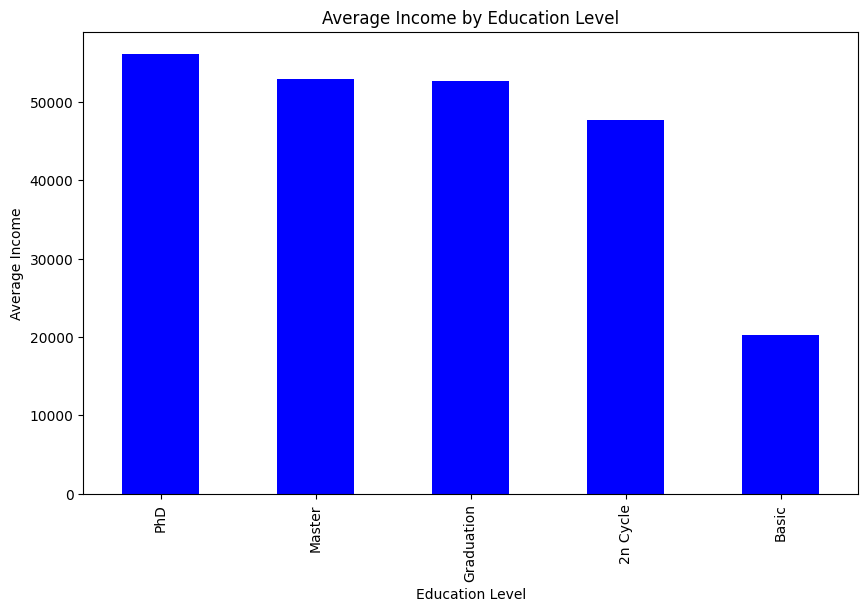

In [34]:
# 1단계: Superstore 마케팅 캠페인 데이터셋 로드
superstore_data = pd.read_csv('/kaggle/input/superstore-marketing-campaign-dataset/superstore_data.csv')

# 열 이름을 출력하여 정확성을 확인
print(superstore_data.columns)

# 2단계: 'Education'으로 그룹화하고 평균 소득 계산
# 그룹화에 사용할 실제 열 이름으로 'Education'을 교체
grouped_data = superstore_data.groupby('Education')['Income'].mean()

# 3단계: 교육 수준에 따른 평균 소득 시각화
plt.figure(figsize=(10, 6))
grouped_data.sort_values(ascending=False).plot(kind='bar', color='blue')
plt.title('Average Income by Education Level')  # 교육 수준에 따른 평균 소득
plt.xlabel('Education Level')  # 교육 수준
plt.ylabel('Average Income')  # 평균 소득
plt.show()

### 프로젝트 16: 정시 비행 비율
- **목표**: 비행기의 정시 성능을 분석합니다.
- **데이터셋**: `flight_data.csv` 파일을 가정하며, 열은 FlightNumber, DepartureTime, ArrivalTime, OnTime으로 구성됩니다.


Satisfaction Percentage: 43.90%


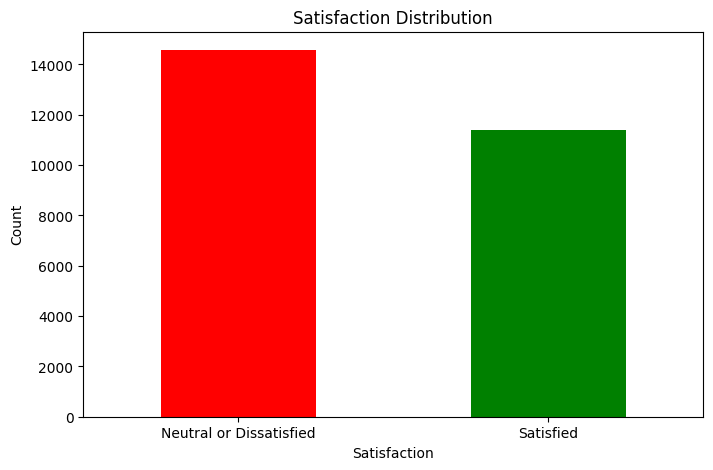

In [35]:
# 1단계: 데이터셋 로드
flight_data = pd.read_csv('/kaggle/input/airline-passenger-satisfaction/test.csv')

# 2단계: 만족도 비율 계산
flight_data['satisfaction'] = flight_data['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})
satisfaction_percentage = flight_data['satisfaction'].mean() * 100

# 3단계: 만족도 비율 출력
print(f"Satisfaction Percentage: {satisfaction_percentage:.2f}%")  # 만족도 비율: 소수점 두 자리까지 표시

# 4단계: 'satisfaction'으로 그룹화하고 분포 시각화
plt.figure(figsize=(8, 5))
flight_data.groupby('satisfaction').size().plot(kind='bar', color=['red', 'green'])
plt.title('Satisfaction Distribution')  # 만족도 분포
plt.xlabel('Satisfaction')  # 만족도
plt.ylabel('Count')  # 수량
plt.xticks(ticks=[0, 1], labels=['Neutral or Dissatisfied', 'Satisfied'], rotation=0)  # x축 레이블 설정
plt.show()

### 프로젝트 17: 범죄 유형별 범죄율
- **목표**: 다양한 범죄 유형에 따른 범죄율을 분석합니다.
- **데이터셋**: `crime_data.csv` 파일을 가정하며, 열은 CrimeType과 CrimeRate로 구성됩니다.


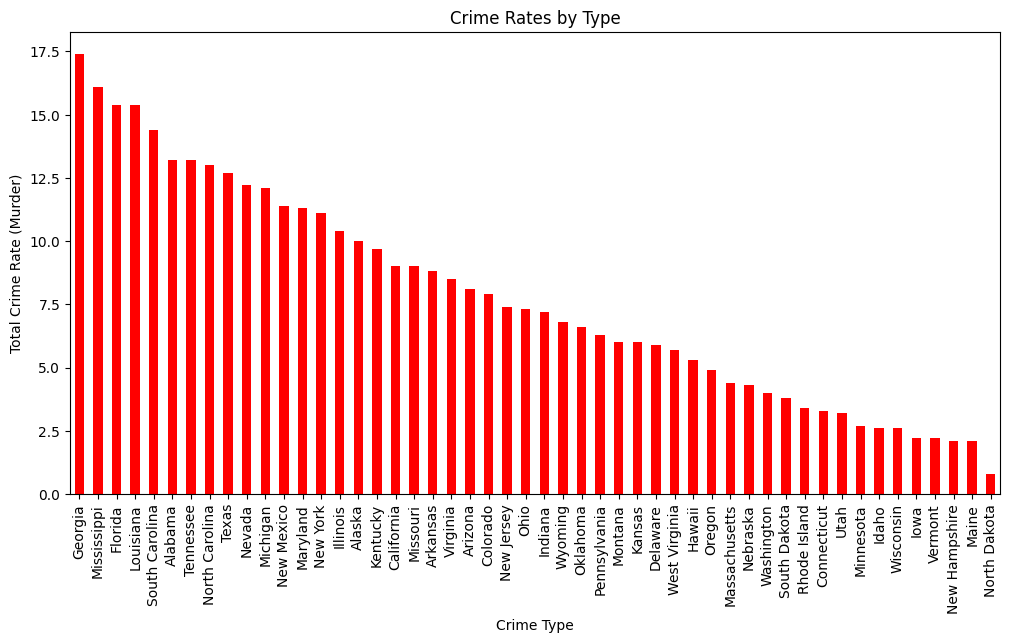

In [36]:
# 1단계: 데이터셋 로드
crime_data = pd.read_csv('/kaggle/input/violent-crime-rates-by-us-state/US_violent_crime.csv')

# 2단계: 범죄 유형별로 그룹화하고 범죄율 시각화
plt.figure(figsize=(12, 6))
crime_data.groupby('Unnamed: 0')['Murder'].sum().sort_values(ascending=False).plot(kind='bar', color='red')
plt.title('Crime Rates by Type')  # 범죄 유형별 범죄율
plt.xlabel('Crime Type')  # 범죄 유형
plt.ylabel('Total Crime Rate (Murder)')  # 총 범죄율 (살인)
plt.show()

### 프로젝트 18: 과목별 학생 성적
- **목표**: 다양한 과목에 대한 학생 성적을 분석하고 시각화합니다.
- **데이터셋**: `student_performance_data.csv` 파일을 가정하며, 열은 StudentID, Subject, Score로 구성됩니다.


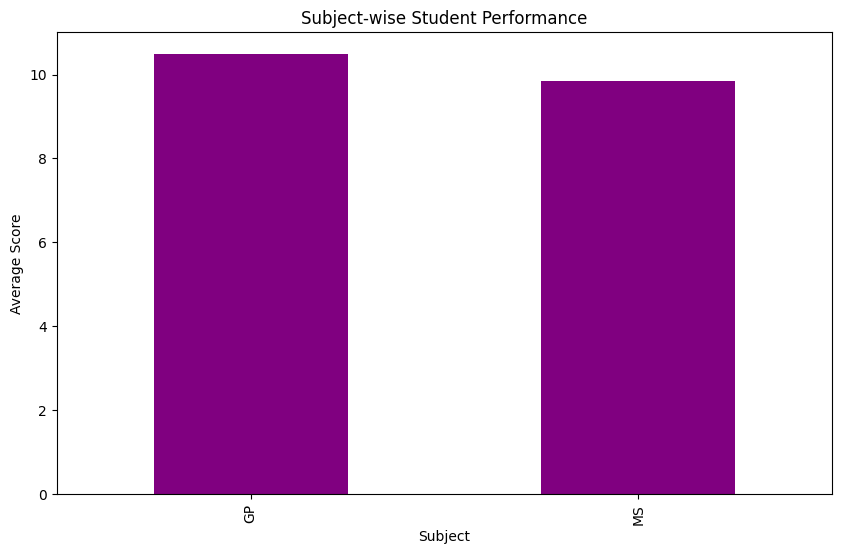

In [37]:
# 1단계: 지정된 인코딩('latin1' 또는 'ISO-8859-1')으로 데이터셋 로드
student_performance_data = pd.read_csv('/kaggle/input/student-performance-data/student_data.csv', encoding='latin1')

# 2단계: 학교별로 그룹화하고 평균 점수 계산
subject_avg_score = student_performance_data.groupby('school')['G3'].mean()

# 3단계: 과목별 학생 성적 시각화
plt.figure(figsize=(10, 6))
subject_avg_score.sort_values(ascending=False).plot(kind='bar', color='purple')
plt.title('Subject-wise Student Performance')  # 과목별 학생 성적
plt.xlabel('Subject')  # 과목
plt.ylabel('Average Score')  # 평균 점수
plt.show()

### 프로젝트 19: 인기 요리 선호도
- **목표**: 인기 요리 선호도를 분석하고 식별합니다.
- **데이터셋**: `cuisine_data.csv` 파일을 가정하며, 열은 CuisineType과 PopularityScore로 구성됩니다.


<ipython-input-38-2ff185e244ef>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = cuisine_data.groupby(['Cuisines', 'Rating Category'])['Overall Rating'].mean().unstack()


<Figure size 1200x600 with 0 Axes>

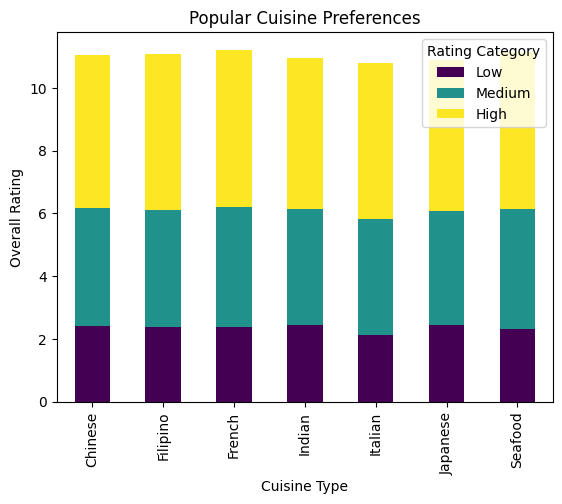

In [38]:
# 1단계: 데이터셋 로드
cuisine_data = pd.read_csv('/kaggle/input/cuisine-rating/Cuisine_rating.csv')

# 2단계: 전체 평점을 기준으로 'Low', 'Medium', 'High'로 데이터 분류
bins = [0, 3, 4, 5]
labels = ['Low', 'Medium', 'High']
cuisine_data['Rating Category'] = pd.cut(cuisine_data['Overall Rating'], bins=bins, labels=labels, include_lowest=True)

# 3단계: 'Cuisines'와 'Rating Category'로 그룹화하고 평균 계산
grouped_data = cuisine_data.groupby(['Cuisines', 'Rating Category'])['Overall Rating'].mean().unstack()

# 4단계: 그룹화된 데이터 시각화
plt.figure(figsize=(12, 6))
grouped_data.plot(kind='bar', stacked=True, colormap='viridis')

plt.title('Popular Cuisine Preferences')  # 인기 있는 요리 선호도
plt.xlabel('Cuisine Type')  # 요리 종류
plt.ylabel('Overall Rating')  # 전체 평점

# 범례 추가
plt.legend(title='Rating Category')

plt.show()

### 프로젝트 20: 지역별 질병 확산
- **목표**: 다양한 지역에서 질병의 확산을 분석하고 시각화합니다.
- **데이터셋**: `disease_spread_data.csv` 파일을 가정하며, 열은 Region, Date, Cases로 구성됩니다.


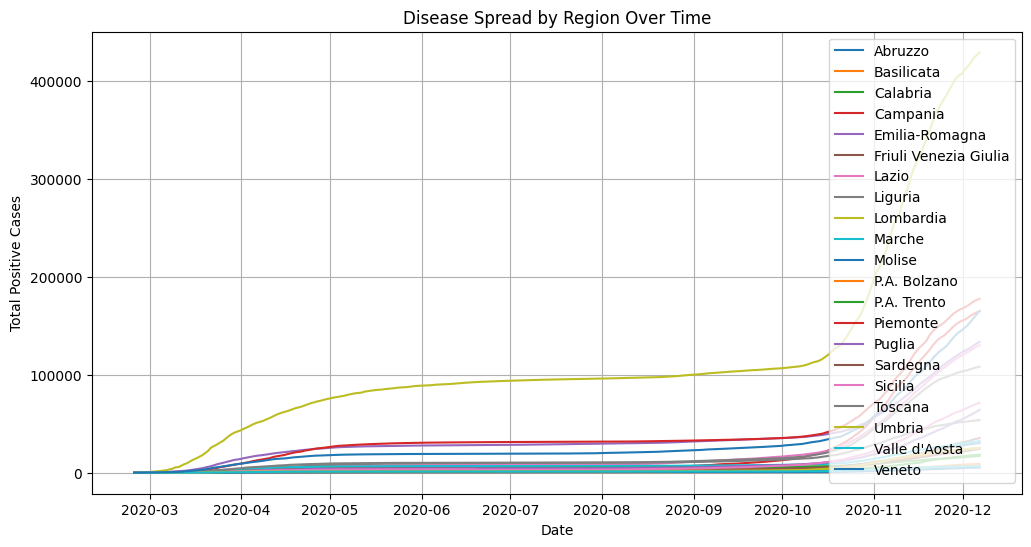

In [39]:
# 1단계: 데이터셋 로드
disease_spread_data = pd.read_csv('/kaggle/input/covid19-in-italy/covid19_italy_region.csv')

# 2단계: 'Date' 열을 datetime 형식으로 변환
disease_spread_data['Date'] = pd.to_datetime(disease_spread_data['Date'])

# 3단계: 지역별로 그룹화하고 시간에 따른 질병 확산 시각화
plt.figure(figsize=(12, 6))
for region, data in disease_spread_data.groupby('RegionName'):
    plt.plot(data['Date'], data['TotalPositiveCases'], label=region)

plt.title('Disease Spread by Region Over Time')  # 지역별 시간에 따른 질병 확산
plt.xlabel('Date')  # 날짜
plt.ylabel('Total Positive Cases')  # 총 양성 사례
plt.legend()  # 범례 추가
plt.grid(True)  # 그리드 추가
plt.show()

###프로젝트 21: 부동산 가격 변화
- **목표**: 시간에 따른 부동산 가격 변화를 분석하고 시각화합니다.
- **데이터셋**: `real_estate_data.csv` 파일을 가정하며, 열은 PropertyID, Date, Price로 구성됩니다.


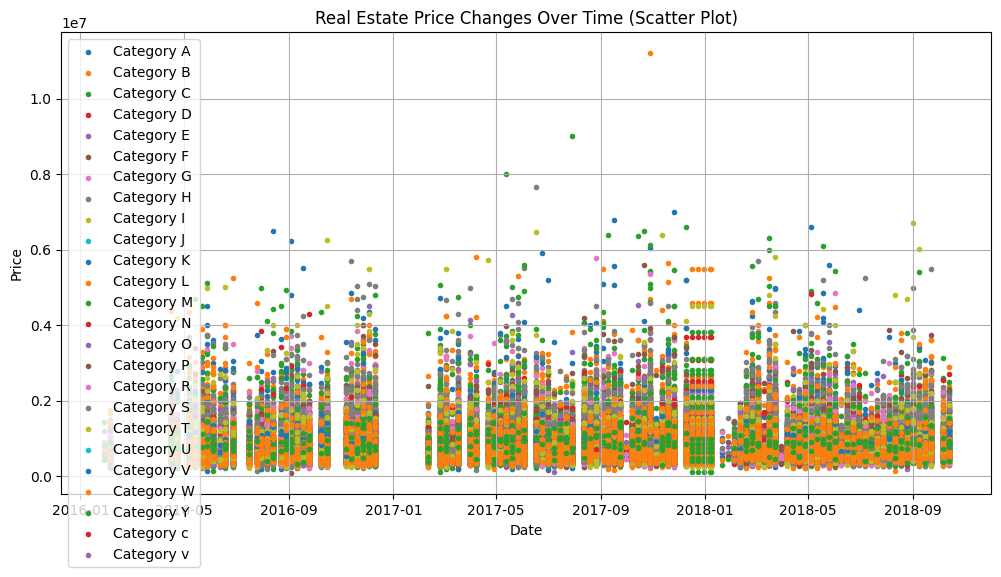


Category Category A suburbs: ['Abbotsford' 'Aberfeldie' 'Airport West' 'Albanvale' 'Albert Park'
 'Albion' 'Alphington' 'Altona' 'Altona Meadows' 'Altona North' 'Armadale'
 'Ascot Vale' 'Ashburton' 'Ashwood' 'Aspendale' 'Aspendale Gardens'
 'Attwood' 'Avondale Heights' 'Ardeer' 'Avonsleigh']

Category Other Categories suburbs: ['Balwyn' 'Balwyn North' 'Bayswater North' 'Beaumaris' 'Bellfield'
 'Bentleigh' 'Bentleigh East' 'Black Rock' 'Blackburn' 'Blackburn North'
 'Blackburn South' 'Bonbeach' 'Boronia' 'Box Hill' 'Braybrook' 'Brighton'
 'Brighton East' 'Broadmeadows' 'Brunswick' 'Brunswick East'
 'Brunswick West' 'Bulleen' 'Bundoora' 'Burwood' 'Burwood East'
 'Camberwell' 'Canterbury' 'Carlton' 'Carlton North' 'Carnegie'
 'Caroline Springs' 'Carrum' 'Carrum Downs' 'Caulfield East'
 'Caulfield North' 'Caulfield South' 'Chadstone' 'Chelsea' 'Cheltenham'
 'Chintin' 'Clayton' 'Clayton South' 'Clifton Hill' 'Coburg'
 'Coburg North' 'Collingwood' 'Craigieburn' 'Cranbourne'
 'Cranbourne Nor

In [40]:
# 1단계: 데이터셋 로드
real_estate_data = pd.read_csv('/kaggle/input/melbourne-housing-market/MELBOURNE_HOUSE_PRICES_LESS.csv')

# 2단계: 'Date' 열을 datetime 형식으로 변환
real_estate_data['Date'] = pd.to_datetime(real_estate_data['Date'], format='%d/%m/%Y')

# 3단계: 첫 글자를 기준으로 교외 지역 분류
real_estate_data['Suburb_Category'] = real_estate_data['Suburb'].str[0]

# 4단계: 교외 지역 카테고리별로 시간에 따른 부동산 가격 변화 산점도 시각화
plt.figure(figsize=(12, 6))

# 5단계: 교외 지역 카테고리별로 그룹화하고 각 카테고리에 대해 산점도 플롯
for category, data in real_estate_data.groupby('Suburb_Category'):
    plt.scatter(data['Date'], data['Price'], label=f'Category {category}', marker='.')

# 6단계: 플롯 세부사항 설정
plt.title('Real Estate Price Changes Over Time (Scatter Plot)')  # 시간에 따른 부동산 가격 변화 (산점도)
plt.xlabel('Date')  # 날짜
plt.ylabel('Price')  # 가격
plt.legend()  # 범례 추가
plt.grid(True)  # 그리드 추가

# 7단계: 플롯 표시
plt.show()

# 8단계: 첫 글자를 기준으로 교외 지역 분류
real_estate_data['Suburb_Category'] = real_estate_data['Suburb'].apply(lambda x: 'Category A' if x.lower().startswith('a') else 'Other Categories')

# 9단계: 각 카테고리의 교외 지역 출력
for category, suburbs in real_estate_data.groupby('Suburb_Category')['Suburb'].unique().items():
    print(f'\nCategory {category} suburbs:', suburbs)  # 카테고리별 교외 지역 출력

### 프로젝트 22: 에너지 소비 피크
- **목표**: 에너지 소비의 피크를 분석하고 식별합니다.
- **데이터셋**: `energy_consumption_data.csv` 파일을 가정하며, 열은 Timestamp와 Consumption으로 구성됩니다.


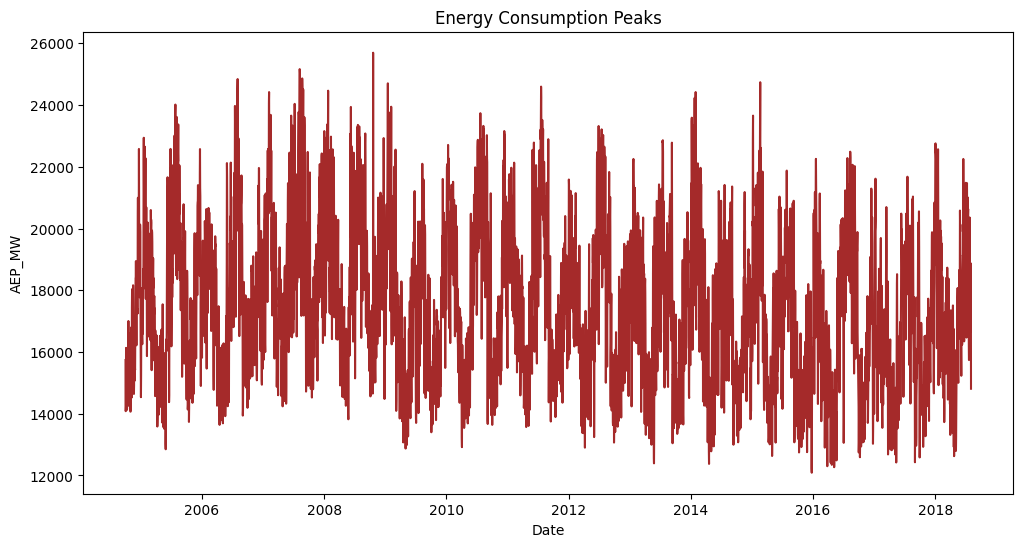

In [41]:
# 1단계: 데이터셋 로드
energy_consumption_data = pd.read_csv('/kaggle/input/hourly-energy-consumption/AEP_hourly.csv')

# 2단계: 'Datetime' 열을 datetime 형식으로 변환
energy_consumption_data['Datetime'] = pd.to_datetime(energy_consumption_data['Datetime'])

# 3단계: 에너지 소비 피크 식별 및 시각화
plt.figure(figsize=(12, 6))

# 날짜별로 그룹화하고 각 날짜의 최대 에너지 소비량 찾기
daily_peak_data = energy_consumption_data.groupby(energy_consumption_data['Datetime'].dt.date)['AEP_MW'].max()

# 식별된 에너지 소비 피크 플롯
plt.plot(daily_peak_data.index, daily_peak_data.values, color='brown')

plt.title('Energy Consumption Peaks')  # 에너지 소비 피크
plt.xlabel('Date')  # 날짜
plt.ylabel('AEP_MW')  # AEP_MW
plt.show()

### 프로젝트 23: 재고 회전율
- **목표**: 재고 회전율을 분석하고 계산합니다.
- **데이터셋**: `inventory_data.csv` 파일을 가정하며, 열은 ProductID, Date, InventoryLevel로 구성됩니다.


<ipython-input-42-9900f0e8034d>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = inventory_data.groupby(bins)[selected_columns].mean()


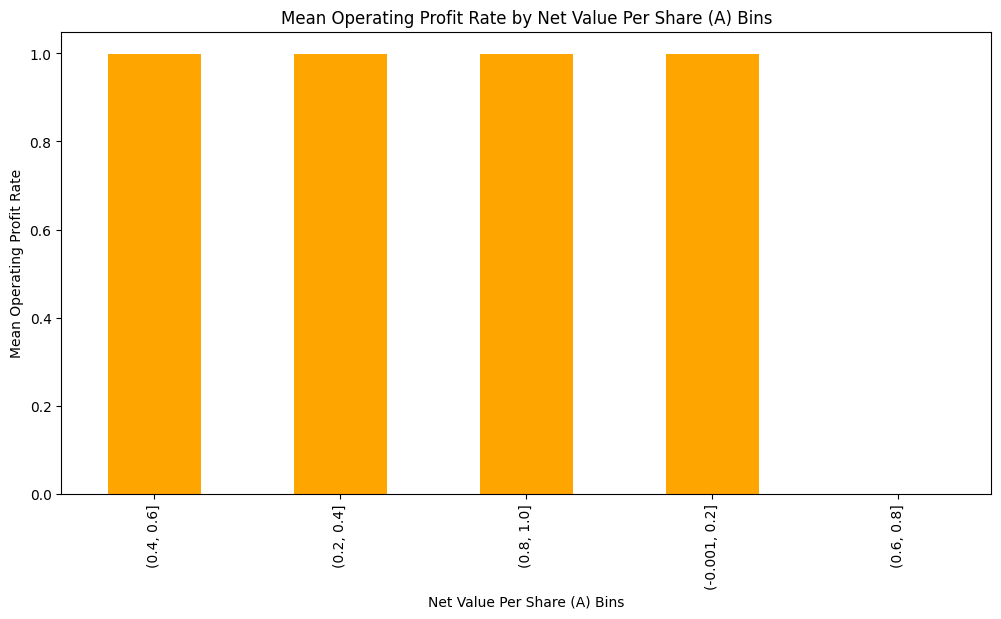

In [42]:
# 1단계: 데이터셋 로드
inventory_data = pd.read_csv('/kaggle/input/company-bankruptcy-prediction/data.csv')

# 열 이름의 앞뒤 공백 제거
inventory_data.columns = inventory_data.columns.str.strip()

# 2단계: 분석을 위한 관련 열 선택
selected_columns = ['Operating Profit Rate', 'Net Value Per Share (A)', 'Gross Profit to Sales', 'Net Income to Total Assets']

# 3단계: 'Net Value Per Share (A)'를 기준으로 구간 생성
bins = pd.cut(inventory_data['Net Value Per Share (A)'], bins=5)  # 구간 수 조정 가능

# 4단계: 구간별로 그룹화하고 선택한 열의 평균 계산
grouped_data = inventory_data.groupby(bins)[selected_columns].mean()

# 5단계: 각 구간의 평균값을 플롯
plt.figure(figsize=(12, 6))
grouped_data.sort_values(by='Operating Profit Rate', ascending=False)['Operating Profit Rate'].plot(kind='bar', color='orange')
plt.title('Mean Operating Profit Rate by Net Value Per Share (A) Bins')  # 순자산 기준 구간별 평균 운영 이익률
plt.xlabel('Net Value Per Share (A) Bins')  # 순자산 기준 구간
plt.ylabel('Mean Operating Profit Rate')  # 평균 운영 이익률
plt.show()

### 프로젝트 24: 교육에 대한 정부 지출
- **목표**: 시간에 따른 교육에 대한 정부 지출을 분석하고 시각화합니다.
- **데이터셋**: `government_spending_data.csv` 파일을 가정하며, 열은 Year와 EducationSpending으로 구성됩니다.



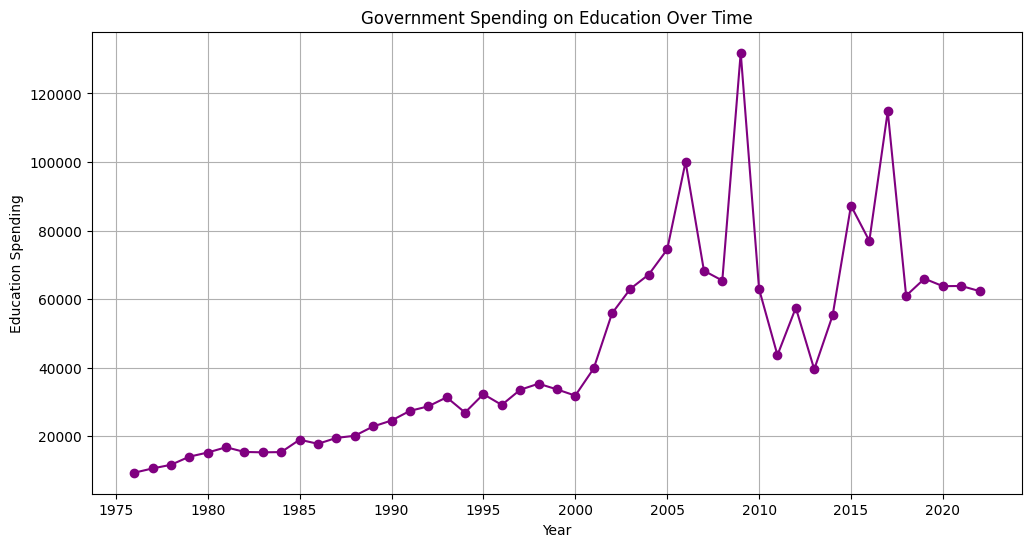

In [43]:
# 1단계: 데이터셋 로드
government_spending_data = pd.read_csv('/kaggle/input/usa-budget-authority-by-agency-19762022/budget.csv')

# 2단계: 'Year' 열을 datetime 형식으로 변환
government_spending_data['Year'] = pd.to_datetime(government_spending_data['Year'], format='%Y')

# 3단계: 시간에 따른 교육 지출 시각화
plt.figure(figsize=(12, 6))

# 연도별로 그룹화하고 매년 교육 지출 합계 계산
education_spending_over_time = government_spending_data.groupby('Year')['Department of Education'].sum()

# 집계된 데이터 플롯
plt.plot(education_spending_over_time.index, education_spending_over_time.values, marker='o', linestyle='-', color='purple')

plt.title('Government Spending on Education Over Time')  # 시간에 따른 정부의 교육 지출
plt.xlabel('Year')  # 연도
plt.ylabel('Education Spending')  # 교육 지출
plt.grid(True)  # 그리드 추가
plt.show()